# **Lab 8.1 Transfer Learning & Multitask Learning**

In [1]:
print("hello")

hello


In [2]:
!nvidia-smi

Thu Oct  3 22:09:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:4E:00.0 Off |                    0 |
| N/A   24C    P0              55W / 400W |      9MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset,random_split
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from collections import Counter
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import random
seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Complete the `MultiLanguageHandwrittenDataset` class below. It should return:
- `image`: the image data
- `label`: the digit label (0-9)
- `language`: the language (Thai or English)


In [5]:
class MultiLanguageHandwrittenDataset(Dataset):
    def __init__(self, root_dirs, languages, transforms=None):
        self.root_dirs = root_dirs
        self.languages = languages
        self.transform = transforms
        self.samples = []
        
        for root_dir, language in zip(self.root_dirs, self.languages):
            for subdir in os.scandir(root_dir):
                if subdir.is_dir():
                    digit_label = int(subdir.name)  # digit label
                    for file in os.scandir(subdir.path):
                        if file.is_file():
                            self.samples.append((file.path, digit_label, self.languages.index(language)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, digit_label, language_label = self.samples[idx]
        image = Image.open(image_path).convert('L')  # Grayscale
        
        if self.transform:
            image = self.transform(image)
        
        return image, digit_label, language_label 

use you `MultiLanguageHandwrittenDataset` here and display the first batch
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

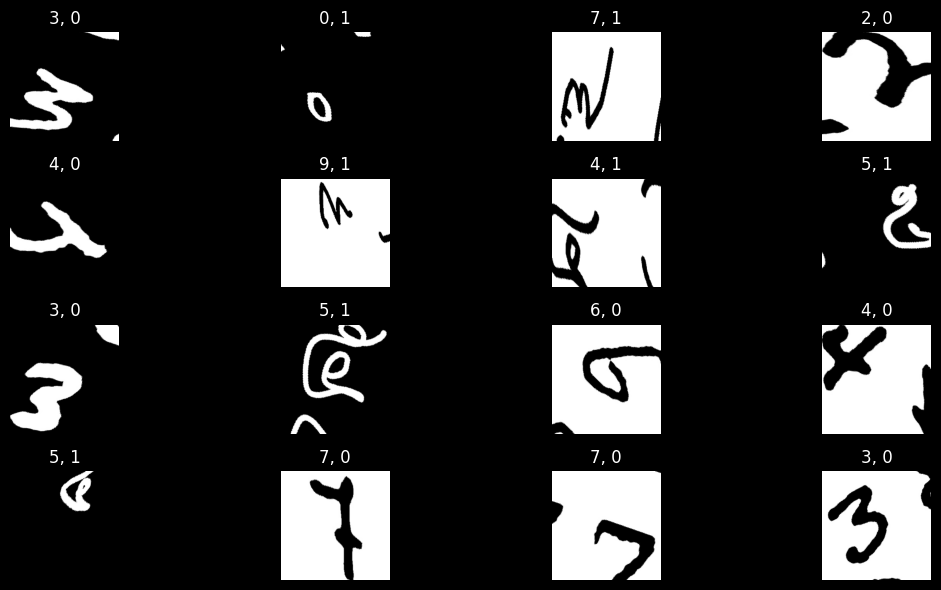

</details>

In [44]:
# import zipfile
# import os

# def unzip_file(zip_file_path, extract_to):
#     # Ensure the output directory exists
#     os.makedirs(extract_to, exist_ok=True)
    
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to)

# # Specify the path to your zip file and the directory to extract it to
# zip_file_path = '/home/tniwatw/Lab/Lab8/data.zip'  # Update with the actual path
# extract_to = 'data'  # Choose your extraction path

# # Unzip the file
# unzip_file(zip_file_path, extract_to)

In [7]:
# Function to visualize the batch of images
def show_batch(images, labels, languages):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)  # Adjust grid size as necessary
        # Permute dimensions to (height, width, channels)
        img = images[i].permute(1, 2, 0).numpy()  # Convert to numpy array for plotting
        plt.imshow(img)  # Use the permuted image
        plt.title(f'Label: {labels[i]}, Language: {languages[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [46]:
# ### START CODE HERE ###
# root_dirs = [r"data\eng-handwritten-dataset", r"data\thai-handwritten-dataset"]
# languages = ['English', 'Thai']

# # Define transformations
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels; VGG16 ซึ่งถูกออกแบบมาให้รับข้อมูลภาพที่มี 3 ช่อง (RGB) เป็นอินพุต
#     transforms.Resize((224, 224)),                # Resize to 224x224 (required for VGG16)
#     transforms.ToTensor(),         # Convert to tensor
# ])

# # Initialize the dataset
# dataset = MultiLanguageHandwrittenDataset(root_dirs, languages, transforms=transform)

# # Define sample sizes for each split
# train_size = 20
# val_size = 5
# test_size = 5

# # Total sample size
# total_sample_size = train_size + val_size + test_size

# # Create a random subset of indices from the dataset
# indices = torch.randperm(len(dataset))[:total_sample_size].tolist()  # Get random indices

# # Create a subset of the dataset using the sampled indices
# sampled_dataset = Subset(dataset, indices)

# # Now split the sampled dataset into train, val, and test
# train_dataset, val_dataset, test_dataset = random_split(sampled_dataset, [train_size, val_size, test_size])

# # Create DataLoaders for each subset
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Shuffle for training
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)      # No shuffle for validation
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)    # No shuffle for testing

# # Display the first batch
# images, labels, languages = next(iter(train_loader))
# show_batch(images, labels, languages)   
# ### END CODE HERE ###

['/home/tniwatw/Lab/Lab8/data/eng-handwritten-dataset', '/home/tniwatw/Lab/Lab8/data/thai-handwritten-dataset']


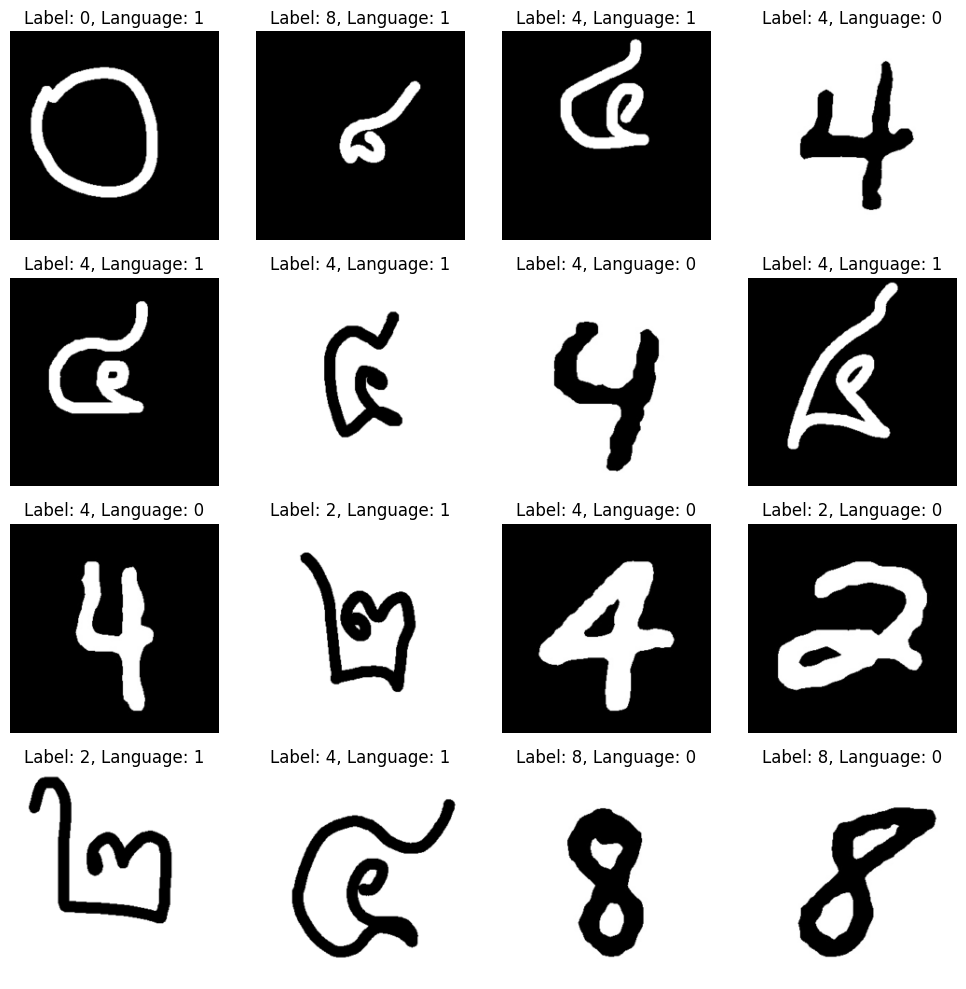

In [8]:
### START CODE HERE ###
# Define the relative paths
eng_dataset_reletive_path = 'data/eng-handwritten-dataset'
thai_dataset_reletive_path = 'data/thai-handwritten-dataset'

# Get the absolute paths
eng_dataset_absolute_path = os.path.abspath(eng_dataset_reletive_path)
thai_dataset_absolute_path = os.path.abspath(thai_dataset_reletive_path)

# Update root_dirs with the absolute paths
root_dirs = [eng_dataset_absolute_path, thai_dataset_absolute_path]

print(root_dirs)

languages = ['English', 'Thai']

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels; VGG16 ซึ่งถูกออกแบบมาให้รับข้อมูลภาพที่มี 3 ช่อง (RGB) เป็นอินพุต
    transforms.Resize((224, 224)),                # Resize to 224x224 (required for VGG16)
    transforms.ToTensor(),         # Convert to tensor
])

# Initialize the dataset
dataset = MultiLanguageHandwrittenDataset(root_dirs, languages, transforms=transform)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Display the first batch
images, labels, languages = next(iter(train_loader))
show_batch(images, labels, languages)   
### END CODE HERE ###

## Transfer learning

Complete the `customVGG16` class below, which can create a pretrained VGG16 model and customize the number of fully connected (FC) layers. It also allows adding new convolutional layers and unfreezing pretrained layers based on their index.

In [48]:
class customVGG16(nn.Module):
    def __init__(self,add_feat_dims=None,h_dims=None,num_classes=10,input_size=(1,28,28),trainable_layers_idx=None):
        super(customVGG16, self).__init__()
        
        # Load the pretrained VGG16 model
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        
        # Change the first convolutional layer to accept the specified number of input channels
        self.vgg16.features[0] = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        # Freeze all convolutional layers by default
        for param in self.vgg16.features.parameters():
            param.requires_grad = False
        
        # Unfreeze specific layers if provided
        if trainable_layers_idx is not None:
            for idx in trainable_layers_idx:
                if idx < len(self.vgg16.features):  # Ensure the index is within bounds
                    for param in self.vgg16.features[idx].parameters():
                        param.requires_grad = True

        # Modify the VGG layers as needed for your input size
        # You can customize how many layers you keep and any additional pooling layers
        layers = list(self.vgg16.features.children())
        # Keep the first few layers and modify the pooling if needed
        self.vgg16.features = nn.Sequential(*layers[:10])  # Adjust as needed
        
        # Add an adaptive average pooling layer
        self.vgg16.features.add_module('adaptive_pool', nn.AdaptiveAvgPool2d((7, 7)))

        # Compute the input size for the fully connected layers
        in_features_fc = self._get_input_size_fc(input_size)

        # Build the classifier
        if add_feat_dims is not None:
            fc_layers = []
            for dim in add_feat_dims:
                fc_layers.append(nn.Linear(in_features_fc, dim))
                fc_layers.append(nn.ReLU())
                fc_layers.append(nn.Dropout(0.5))
                in_features_fc = dim
            self.classifier = nn.Sequential(*fc_layers, nn.Linear(in_features_fc, num_classes))
        elif h_dims is not None:
            fc_layers = []
            for i, hdim in enumerate(h_dims):
                if i == 0:
                    fc_layers.append(nn.Linear(in_features_fc, hdim))
                else:
                    fc_layers.append(nn.Linear(h_dims[i - 1], hdim))
                fc_layers.append(nn.Dropout(0.4))
                fc_layers.append(nn.ReLU(inplace=True))
            fc_layers.append(nn.Linear(h_dims[-1], num_classes))
            self.classifier = nn.Sequential(*fc_layers)
        else:
            self.classifier = nn.Linear(in_features_fc, num_classes)

    def _get_input_size_fc(self, input_shape):
        """Compute the input size for the fully connected layer based on the input size."""
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.vgg16.features(x)
            x = torch.flatten(x, 1)
            return x.size(1)

    def forward(self, x):
        """Define the forward pass."""
        # Forward pass through VGG16 features
        x = self.vgg16.features(x)
        x = torch.flatten(x, 1)  # Flatten starting from dimension 1
        
        # Forward pass through classifier
        x = self.classifier(x)
        return x


Example usage
```
trainable_layers_idx = [-1,-2,-3,-4,-5]
model = customVGG16(add_feat_dims=[512],h_dims=[512,256,256],input_size=(3,224,224),trainable_layers_idx=trainable_layers_idx)

```


Complete the `train` function below, which logs Loss/train, Accuracy/train, Loss/test, and Accuracy/test to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).Then, complete the evaluate_task function, which prints the classification report and plots the confusion matrix

In [13]:
def train(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu', task='digit'):
    print("🤖 Training on", device)
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total_train = 0

        # Training loop
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch + 1}/{epochs}]', unit='batch')
        for images, labels, languages in train_bar:
            images = images.to(device)

            if task == 'digit':
                labels = labels.to(device)
                targets = labels
            elif task == 'language':
                languages = languages.to(device)
                targets = languages

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Calculate training loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == targets).sum().item()
            total_train += targets.size(0)

            # Update progress bar
            train_bar.set_postfix(loss=train_loss / (len(train_bar)))

        # Log training metrics to TensorBoard
        train_loss /= len(train_loader)
        train_accuracy = train_correct / total_train
        if writer:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train', train_accuracy, epoch)

        # Validation loop
        model.eval()
        val_loss, val_correct = 0.0, 0
        total_val = 0
        y_true, y_pred = [], []

        val_bar = tqdm(val_loader, desc='📄 Validation', unit='batch')
        with torch.no_grad():
            for images, labels, languages in val_bar:
                images = images.to(device)

                if task == 'digit':
                    labels = labels.to(device)
                    targets = labels
                elif task == 'language':
                    languages = languages.to(device)
                    targets = languages

                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, targets)

                # Calculate validation loss and accuracy
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == targets).sum().item()
                total_val += targets.size(0)

                # Collect true and predicted labels for evaluation
                y_true.extend(targets.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

                # Debugging output
                # print("Targets:", targets.cpu().numpy())
                # print("Predicted:", predicted.cpu().numpy())

                # Update validation progress bar
                val_bar.set_postfix(loss=val_loss / (len(val_bar)))

        # Log validation metrics to TensorBoard
        val_loss /= len(val_loader)
        val_accuracy = val_correct / total_val
        if writer:
            writer.add_scalar('Loss/val', val_loss, epoch)
            writer.add_scalar('Accuracy/val', val_accuracy, epoch)

        print(f'Epoch [{epoch + 1}/{epochs}]\n'
            f'Loss:\t\t{train_loss:.4f},\tAccuracy:\t{train_accuracy:.4f}\n'
            f'Val Loss:\t{val_loss:.4f},\tVal Accuracy:\t{val_accuracy:.4f}')

        # Save checkpoint if path is provided
        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)

        # print("\n✅ Epoch completed, evaluating the task")
        # # Evaluate task if specified
        # evaluate_task(y_true, y_pred, task)

def evaluate_task(y_true, y_pred, task_name="Classification Task"):
    # Print the classification report
    print(f"{task_name} - Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=1))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{task_name} - Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Transfer learning for Digit classification task
Declare the `customVGG16` model with custom layers of your choice. Then, split the dataset into training, validation, and test sets, and proceed to train the model.

In [50]:
# Evaluate on the test set
def evaluate_on_test_set(model, test_loader, device, task="digit"):
    model.eval()
    test_correct = 0
    total_test = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels, languages in test_loader:
            images = images.to(device)

            if task == 'digit':
                labels = labels.to(device)
                targets = labels
            elif task == 'language':
                languages = languages.to(device)
                targets = languages

            # Get the model's outputs; handle the output being a tuple
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Assuming the first element is the relevant output

            _, predicted = torch.max(outputs, 1)

            test_correct += (predicted == targets).sum().item()
            total_test += targets.size(0)

            # Collect true and predicted labels for evaluation
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = test_correct / total_test
    print(f'Test Accuracy: {test_accuracy:.4f}')
    evaluate_task(y_true, y_pred, task_name=task)

In [64]:
# Define the parameters
# Initialize the model with specified configurations
trainable_layers_idx = [-1, -2, -3, -4, -5]  # Layers to unfreeze
model1 = customVGG16(add_feat_dims=[512], h_dims=[512, 256, 256], input_size=(3, 224, 224), trainable_layers_idx=trainable_layers_idx)

# Setup TensorBoard for logging
writer = SummaryWriter(log_dir='runs/custom_vgg16_digit_experiment')

# Define an optimizer and loss function
opt = optim.Adam(model1.parameters(), lr=0.001)  # Adam optimizer
loss_fn = nn.CrossEntropyLoss()  # Common loss for classification tasks

num_epochs = 100  # Set number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train(model1, opt, loss_fn, train_loader, val_loader, epochs=num_epochs, writer=writer, device=device, task='digit')

writer.close()


🤖 Training on cuda


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 16.92batch/s, loss=2.19]


Epoch [1/100]
Loss:		2.3413,	Accuracy:	0.1510
Val Loss:	2.1875,	Val Accuracy:	0.2952


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.01batch/s, loss=2.06]


Epoch [2/100]
Loss:		2.1565,	Accuracy:	0.2212
Val Loss:	2.0556,	Val Accuracy:	0.3600


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.98batch/s, loss=1.87]


Epoch [3/100]
Loss:		2.0130,	Accuracy:	0.2710
Val Loss:	1.8733,	Val Accuracy:	0.4610


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.93batch/s, loss=1.72]


Epoch [4/100]
Loss:		1.8741,	Accuracy:	0.3224
Val Loss:	1.7195,	Val Accuracy:	0.5048


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.82batch/s, loss=1.56]


Epoch [5/100]
Loss:		1.7551,	Accuracy:	0.3755
Val Loss:	1.5617,	Val Accuracy:	0.5276


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.00batch/s, loss=1.48]


Epoch [6/100]
Loss:		1.6786,	Accuracy:	0.3812
Val Loss:	1.4791,	Val Accuracy:	0.5467


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 16.80batch/s, loss=1.46]


Epoch [7/100]
Loss:		1.5933,	Accuracy:	0.4086
Val Loss:	1.4618,	Val Accuracy:	0.5829


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.18batch/s, loss=1.32]


Epoch [8/100]
Loss:		1.5712,	Accuracy:	0.4298
Val Loss:	1.3189,	Val Accuracy:	0.6229


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.97batch/s, loss=1.26]


Epoch [9/100]
Loss:		1.5457,	Accuracy:	0.4314
Val Loss:	1.2599,	Val Accuracy:	0.6038


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.11batch/s, loss=1.25]


Epoch [10/100]
Loss:		1.4851,	Accuracy:	0.4396
Val Loss:	1.2454,	Val Accuracy:	0.6248


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.99batch/s, loss=1.16]


Epoch [11/100]
Loss:		1.4754,	Accuracy:	0.4473
Val Loss:	1.1582,	Val Accuracy:	0.6762


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.05batch/s, loss=1.19]


Epoch [12/100]
Loss:		1.4364,	Accuracy:	0.4690
Val Loss:	1.1938,	Val Accuracy:	0.6362


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.11batch/s, loss=1.12]


Epoch [13/100]
Loss:		1.4120,	Accuracy:	0.4796
Val Loss:	1.1195,	Val Accuracy:	0.6457


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.44batch/s, loss=1.13]


Epoch [14/100]
Loss:		1.3882,	Accuracy:	0.4845
Val Loss:	1.1331,	Val Accuracy:	0.6533


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.31batch/s, loss=1.13]


Epoch [15/100]
Loss:		1.3562,	Accuracy:	0.5008
Val Loss:	1.1333,	Val Accuracy:	0.6438


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.16batch/s, loss=1.12]


Epoch [16/100]
Loss:		1.3469,	Accuracy:	0.5037
Val Loss:	1.1221,	Val Accuracy:	0.6743


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.19batch/s, loss=1.11]


Epoch [17/100]
Loss:		1.2979,	Accuracy:	0.5200
Val Loss:	1.1051,	Val Accuracy:	0.6629


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.38batch/s, loss=1.06]


Epoch [18/100]
Loss:		1.3051,	Accuracy:	0.5073
Val Loss:	1.0569,	Val Accuracy:	0.6933


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.16batch/s, loss=1.08]


Epoch [19/100]
Loss:		1.2749,	Accuracy:	0.5224
Val Loss:	1.0846,	Val Accuracy:	0.6590


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.15batch/s, loss=1.01]


Epoch [20/100]
Loss:		1.3164,	Accuracy:	0.5024
Val Loss:	1.0112,	Val Accuracy:	0.6838


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.71batch/s, loss=1.04]


Epoch [21/100]
Loss:		1.3196,	Accuracy:	0.5029
Val Loss:	1.0435,	Val Accuracy:	0.6857


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.33batch/s, loss=1.04]


Epoch [22/100]
Loss:		1.2498,	Accuracy:	0.5384
Val Loss:	1.0357,	Val Accuracy:	0.6971


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.37batch/s, loss=1.03]


Epoch [23/100]
Loss:		1.2400,	Accuracy:	0.5449
Val Loss:	1.0267,	Val Accuracy:	0.7124


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.32batch/s, loss=1.05]


Epoch [24/100]
Loss:		1.2138,	Accuracy:	0.5437
Val Loss:	1.0519,	Val Accuracy:	0.6952


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.33batch/s, loss=1.08]


Epoch [25/100]
Loss:		1.2247,	Accuracy:	0.5347
Val Loss:	1.0793,	Val Accuracy:	0.6819


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.33batch/s, loss=0.947]


Epoch [26/100]
Loss:		1.2132,	Accuracy:	0.5408
Val Loss:	0.9473,	Val Accuracy:	0.7333


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.09batch/s, loss=0.979]


Epoch [27/100]
Loss:		1.2217,	Accuracy:	0.5461
Val Loss:	0.9792,	Val Accuracy:	0.7143


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.35batch/s, loss=1.03]


Epoch [28/100]
Loss:		1.2398,	Accuracy:	0.5261
Val Loss:	1.0308,	Val Accuracy:	0.6914


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.17batch/s, loss=0.991]


Epoch [29/100]
Loss:		1.2130,	Accuracy:	0.5453
Val Loss:	0.9913,	Val Accuracy:	0.6933


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.08batch/s, loss=1.02]


Epoch [30/100]
Loss:		1.2524,	Accuracy:	0.5408
Val Loss:	1.0189,	Val Accuracy:	0.6876


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.14batch/s, loss=0.996]


Epoch [31/100]
Loss:		1.2198,	Accuracy:	0.5429
Val Loss:	0.9956,	Val Accuracy:	0.7276


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.43batch/s, loss=0.936]


Epoch [32/100]
Loss:		1.2433,	Accuracy:	0.5237
Val Loss:	0.9356,	Val Accuracy:	0.7295


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 16.85batch/s, loss=0.929]


Epoch [33/100]
Loss:		1.1815,	Accuracy:	0.5592
Val Loss:	0.9294,	Val Accuracy:	0.7314


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.03batch/s, loss=0.939]


Epoch [34/100]
Loss:		1.1928,	Accuracy:	0.5518
Val Loss:	0.9390,	Val Accuracy:	0.7410


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.01batch/s, loss=0.933]


Epoch [35/100]
Loss:		1.1920,	Accuracy:	0.5302
Val Loss:	0.9331,	Val Accuracy:	0.7162


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.99batch/s, loss=0.96]


Epoch [36/100]
Loss:		1.1821,	Accuracy:	0.5531
Val Loss:	0.9598,	Val Accuracy:	0.7105


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.04batch/s, loss=0.929]


Epoch [37/100]
Loss:		1.2084,	Accuracy:	0.5453
Val Loss:	0.9288,	Val Accuracy:	0.7276


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.93batch/s, loss=0.917]


Epoch [38/100]
Loss:		1.1633,	Accuracy:	0.5600
Val Loss:	0.9170,	Val Accuracy:	0.7352


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.06batch/s, loss=0.893]


Epoch [39/100]
Loss:		1.1667,	Accuracy:	0.5555
Val Loss:	0.8926,	Val Accuracy:	0.7333


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.20batch/s, loss=0.858]


Epoch [40/100]
Loss:		1.1557,	Accuracy:	0.5584
Val Loss:	0.8579,	Val Accuracy:	0.7486


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.10batch/s, loss=1.03]


Epoch [41/100]
Loss:		1.1636,	Accuracy:	0.5759
Val Loss:	1.0338,	Val Accuracy:	0.7048


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.17batch/s, loss=0.972]


Epoch [42/100]
Loss:		1.1636,	Accuracy:	0.5506
Val Loss:	0.9715,	Val Accuracy:	0.7143


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.09batch/s, loss=0.861]


Epoch [43/100]
Loss:		1.1471,	Accuracy:	0.5682
Val Loss:	0.8613,	Val Accuracy:	0.7371


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.06batch/s, loss=0.859]


Epoch [44/100]
Loss:		1.1062,	Accuracy:	0.5816
Val Loss:	0.8593,	Val Accuracy:	0.7352


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.07batch/s, loss=0.848]


Epoch [45/100]
Loss:		1.1734,	Accuracy:	0.5494
Val Loss:	0.8482,	Val Accuracy:	0.7429


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.16batch/s, loss=0.886]


Epoch [46/100]
Loss:		1.1165,	Accuracy:	0.5739
Val Loss:	0.8858,	Val Accuracy:	0.7295


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.91batch/s, loss=0.826]


Epoch [47/100]
Loss:		1.0959,	Accuracy:	0.5849
Val Loss:	0.8261,	Val Accuracy:	0.7410


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.82batch/s, loss=0.853]


Epoch [48/100]
Loss:		1.0642,	Accuracy:	0.6012
Val Loss:	0.8532,	Val Accuracy:	0.7352


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.89batch/s, loss=0.908]


Epoch [49/100]
Loss:		1.1344,	Accuracy:	0.5571
Val Loss:	0.9080,	Val Accuracy:	0.7067


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.90batch/s, loss=0.84]


Epoch [50/100]
Loss:		1.1078,	Accuracy:	0.5849
Val Loss:	0.8400,	Val Accuracy:	0.7562


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.08batch/s, loss=0.903]


Epoch [51/100]
Loss:		1.1015,	Accuracy:	0.5792
Val Loss:	0.9026,	Val Accuracy:	0.7448


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.83batch/s, loss=0.886]


Epoch [52/100]
Loss:		1.0813,	Accuracy:	0.5959
Val Loss:	0.8858,	Val Accuracy:	0.7352


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.03batch/s, loss=0.927]


Epoch [53/100]
Loss:		1.0579,	Accuracy:	0.5939
Val Loss:	0.9266,	Val Accuracy:	0.7086


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.92batch/s, loss=0.905]


Epoch [54/100]
Loss:		1.0965,	Accuracy:	0.5894
Val Loss:	0.9045,	Val Accuracy:	0.6952


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.99batch/s, loss=0.877]


Epoch [55/100]
Loss:		1.0692,	Accuracy:	0.5959
Val Loss:	0.8773,	Val Accuracy:	0.7429


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.02batch/s, loss=0.859]


Epoch [56/100]
Loss:		1.0626,	Accuracy:	0.6090
Val Loss:	0.8586,	Val Accuracy:	0.7333


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.21batch/s, loss=0.884]


Epoch [57/100]
Loss:		1.1088,	Accuracy:	0.5780
Val Loss:	0.8842,	Val Accuracy:	0.7410


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.66batch/s, loss=0.913]


Epoch [58/100]
Loss:		1.0876,	Accuracy:	0.5747
Val Loss:	0.9130,	Val Accuracy:	0.7162


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.87batch/s, loss=0.883]


Epoch [59/100]
Loss:		1.1100,	Accuracy:	0.5784
Val Loss:	0.8825,	Val Accuracy:	0.7371


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.09batch/s, loss=0.858]


Epoch [60/100]
Loss:		1.0664,	Accuracy:	0.5935
Val Loss:	0.8576,	Val Accuracy:	0.7276


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.90batch/s, loss=0.888]


Epoch [61/100]
Loss:		1.0318,	Accuracy:	0.6147
Val Loss:	0.8883,	Val Accuracy:	0.7543


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.05batch/s, loss=0.823]


Epoch [62/100]
Loss:		1.0595,	Accuracy:	0.5955
Val Loss:	0.8225,	Val Accuracy:	0.7429


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 12.67batch/s, loss=0.851]


Epoch [63/100]
Loss:		1.0717,	Accuracy:	0.5890
Val Loss:	0.8513,	Val Accuracy:	0.7448


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.94batch/s, loss=0.816]


Epoch [64/100]
Loss:		1.0875,	Accuracy:	0.5951
Val Loss:	0.8165,	Val Accuracy:	0.7505


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.88batch/s, loss=0.83]


Epoch [65/100]
Loss:		1.0551,	Accuracy:	0.5824
Val Loss:	0.8303,	Val Accuracy:	0.7486


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.96batch/s, loss=0.943]


Epoch [66/100]
Loss:		1.0172,	Accuracy:	0.5976
Val Loss:	0.9433,	Val Accuracy:	0.7181


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.96batch/s, loss=0.916]


Epoch [67/100]
Loss:		1.0445,	Accuracy:	0.5984
Val Loss:	0.9157,	Val Accuracy:	0.7295


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.90batch/s, loss=0.829]


Epoch [68/100]
Loss:		1.0227,	Accuracy:	0.5971
Val Loss:	0.8286,	Val Accuracy:	0.7543


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.03batch/s, loss=0.858]


Epoch [69/100]
Loss:		1.0463,	Accuracy:	0.5980
Val Loss:	0.8577,	Val Accuracy:	0.7429


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.11batch/s, loss=0.828]


Epoch [70/100]
Loss:		1.0352,	Accuracy:	0.5996
Val Loss:	0.8278,	Val Accuracy:	0.7562


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.50batch/s, loss=0.853]


Epoch [71/100]
Loss:		1.0526,	Accuracy:	0.5894
Val Loss:	0.8531,	Val Accuracy:	0.7752


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.97batch/s, loss=0.836]


Epoch [72/100]
Loss:		1.0105,	Accuracy:	0.6020
Val Loss:	0.8356,	Val Accuracy:	0.7676


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.91batch/s, loss=0.844]


Epoch [73/100]
Loss:		1.0367,	Accuracy:	0.6012
Val Loss:	0.8440,	Val Accuracy:	0.7505


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.03batch/s, loss=0.84]


Epoch [74/100]
Loss:		1.0336,	Accuracy:	0.6098
Val Loss:	0.8395,	Val Accuracy:	0.7543


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.12batch/s, loss=0.814]


Epoch [75/100]
Loss:		1.0278,	Accuracy:	0.6065
Val Loss:	0.8143,	Val Accuracy:	0.7467


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.99batch/s, loss=0.81]


Epoch [76/100]
Loss:		1.0053,	Accuracy:	0.6106
Val Loss:	0.8101,	Val Accuracy:	0.7676


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.19batch/s, loss=0.856]


Epoch [77/100]
Loss:		1.0017,	Accuracy:	0.6180
Val Loss:	0.8559,	Val Accuracy:	0.7486


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.22batch/s, loss=0.867]


Epoch [78/100]
Loss:		0.9726,	Accuracy:	0.6237
Val Loss:	0.8665,	Val Accuracy:	0.7352


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.27batch/s, loss=0.837]


Epoch [79/100]
Loss:		0.9709,	Accuracy:	0.6196
Val Loss:	0.8372,	Val Accuracy:	0.7543


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.95batch/s, loss=0.859]


Epoch [80/100]
Loss:		1.0329,	Accuracy:	0.5996
Val Loss:	0.8585,	Val Accuracy:	0.7181


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.06batch/s, loss=0.812]


Epoch [81/100]
Loss:		0.9955,	Accuracy:	0.6216
Val Loss:	0.8118,	Val Accuracy:	0.7505


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.84batch/s, loss=0.867]


Epoch [82/100]
Loss:		0.9986,	Accuracy:	0.6151
Val Loss:	0.8666,	Val Accuracy:	0.7562


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.96batch/s, loss=0.829]


Epoch [83/100]
Loss:		1.0080,	Accuracy:	0.6045
Val Loss:	0.8292,	Val Accuracy:	0.7352


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.85batch/s, loss=0.854]


Epoch [84/100]
Loss:		1.0225,	Accuracy:	0.6082
Val Loss:	0.8544,	Val Accuracy:	0.7505


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.16batch/s, loss=0.82]


Epoch [85/100]
Loss:		0.9818,	Accuracy:	0.6339
Val Loss:	0.8195,	Val Accuracy:	0.7581


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.92batch/s, loss=0.834]


Epoch [86/100]
Loss:		1.0164,	Accuracy:	0.6118
Val Loss:	0.8341,	Val Accuracy:	0.7562


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.06batch/s, loss=0.845]


Epoch [87/100]
Loss:		0.9900,	Accuracy:	0.6147
Val Loss:	0.8453,	Val Accuracy:	0.7524


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.04batch/s, loss=0.822]


Epoch [88/100]
Loss:		1.0463,	Accuracy:	0.6008
Val Loss:	0.8218,	Val Accuracy:	0.7371


📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.12batch/s, loss=0.82]


Epoch [89/100]
Loss:		0.9632,	Accuracy:	0.6265
Val Loss:	0.8203,	Val Accuracy:	0.7714


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.92batch/s, loss=0.828]


Epoch [90/100]
Loss:		0.9953,	Accuracy:	0.6237
Val Loss:	0.8278,	Val Accuracy:	0.7467


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:03<00:00, 10.22batch/s, loss=0.823]


Epoch [91/100]
Loss:		0.9642,	Accuracy:	0.6347
Val Loss:	0.8235,	Val Accuracy:	0.7505


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.93batch/s, loss=0.885]


Epoch [92/100]
Loss:		0.9747,	Accuracy:	0.6273
Val Loss:	0.8846,	Val Accuracy:	0.7390


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.78batch/s, loss=0.828]


Epoch [93/100]
Loss:		1.0125,	Accuracy:	0.6188
Val Loss:	0.8276,	Val Accuracy:	0.7543


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.04batch/s, loss=0.862]


Epoch [94/100]
Loss:		0.9679,	Accuracy:	0.6286
Val Loss:	0.8621,	Val Accuracy:	0.7524


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.02batch/s, loss=0.813]


Epoch [95/100]
Loss:		0.9594,	Accuracy:	0.6327
Val Loss:	0.8130,	Val Accuracy:	0.7695


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.15batch/s, loss=0.849]


Epoch [96/100]
Loss:		0.9376,	Accuracy:	0.6400
Val Loss:	0.8493,	Val Accuracy:	0.7486


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.01batch/s, loss=0.811]


Epoch [97/100]
Loss:		0.9588,	Accuracy:	0.6233
Val Loss:	0.8115,	Val Accuracy:	0.7581


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.09batch/s, loss=0.855]


Epoch [98/100]
Loss:		0.9966,	Accuracy:	0.6155
Val Loss:	0.8551,	Val Accuracy:	0.7600


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.12batch/s, loss=0.822]


Epoch [99/100]
Loss:		0.9336,	Accuracy:	0.6351
Val Loss:	0.8219,	Val Accuracy:	0.7505


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.92batch/s, loss=0.828]

Epoch [100/100]
Loss:		0.9546,	Accuracy:	0.6294
Val Loss:	0.8284,	Val Accuracy:	0.7638


use `evaluate_task` to evlauate you model1 here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.75      0.94      0.83        32
           2       0.66      0.54      0.59        39
           3       0.76      0.54      0.63        35
           4       0.68      0.53      0.60        47
           5       0.52      0.42      0.47        33
           6       0.59      0.88      0.71        33
           7       0.46      0.59      0.52        27
           8       0.70      0.65      0.67        43
           9       0.85      0.83      0.84        35

    accuracy                           0.67       350
   macro avg       0.67      0.68      0.67       350
weighted avg       0.68      0.67      0.67       350

```

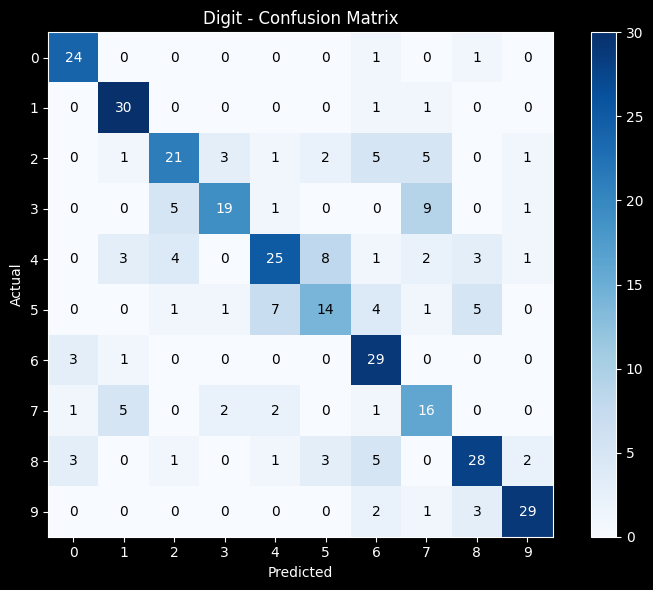

</details>

Test Accuracy: 0.7410
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        61
           1       0.69      0.87      0.77        46
           2       0.70      0.85      0.77        54
           3       0.67      0.65      0.66        51
           4       0.74      0.72      0.73        58
           5       0.67      0.77      0.72        56
           6       0.82      0.77      0.80        53
           7       0.81      0.68      0.74        44
           8       0.70      0.61      0.65        51
           9       0.73      0.71      0.72        51

    accuracy                           0.74       525
   macro avg       0.75      0.74      0.74       525
weighted avg       0.75      0.74      0.74       525



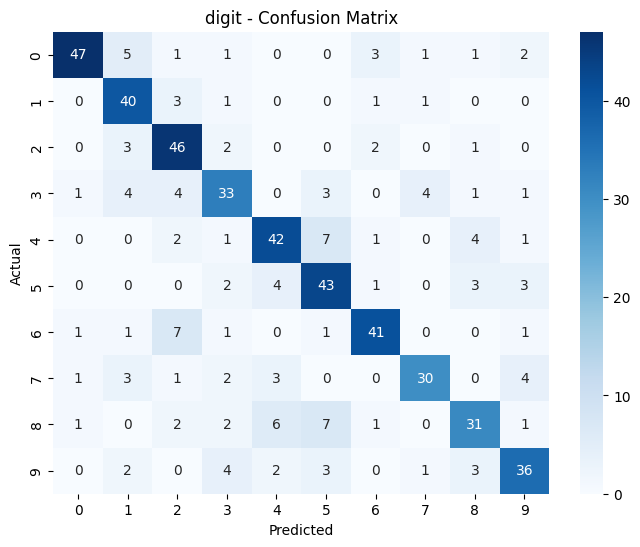

In [65]:
### START CODE HERE ###
evaluate_on_test_set(model1, test_loader, device, task = 'digit')
### END CODE HERE ###

### Transfer learning for Language classification task
Declare a NEW `customVGG16` model with custom layers of your choice.

🤖 Training on cuda


📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:03<00:00, 10.02batch/s, loss=0.299]

Epoch [1/10]
Loss:		0.5321,	Accuracy:	0.7584
Val Loss:	0.2987,	Val Accuracy:	0.8933

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       247
           1       0.90      0.90      0.90       278

    accuracy                           0.89       525
   macro avg       0.89      0.89      0.89       525
weighted avg       0.89      0.89      0.89       525



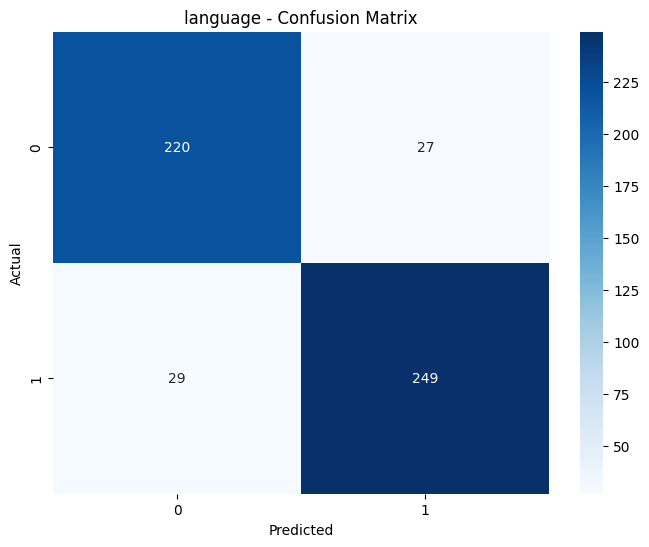

📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.31batch/s, loss=0.24]


Epoch [2/10]
Loss:		0.3319,	Accuracy:	0.8706
Val Loss:	0.2396,	Val Accuracy:	0.9143

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       247
           1       0.89      0.95      0.92       278

    accuracy                           0.91       525
   macro avg       0.92      0.91      0.91       525
weighted avg       0.92      0.91      0.91       525



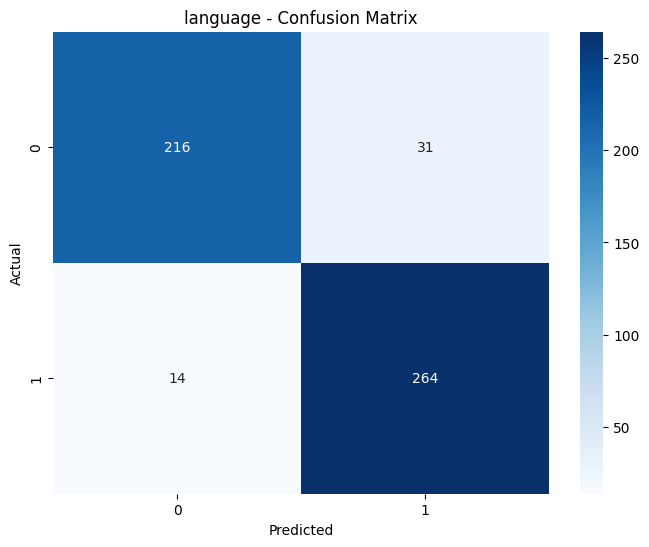

📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.41batch/s, loss=0.219]


Epoch [3/10]
Loss:		0.2798,	Accuracy:	0.8861
Val Loss:	0.2193,	Val Accuracy:	0.9181

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       247
           1       0.97      0.87      0.92       278

    accuracy                           0.92       525
   macro avg       0.92      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525



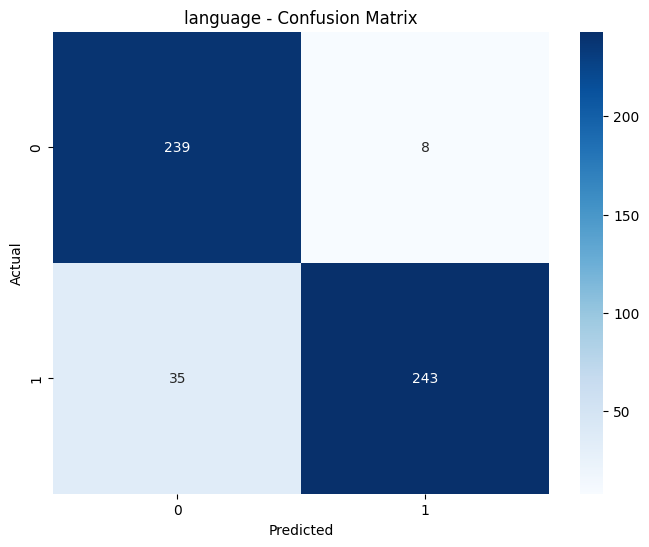

📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.32batch/s, loss=0.264]


Epoch [4/10]
Loss:		0.2577,	Accuracy:	0.8955
Val Loss:	0.2643,	Val Accuracy:	0.9067

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       247
           1       0.87      0.97      0.92       278

    accuracy                           0.91       525
   macro avg       0.92      0.90      0.91       525
weighted avg       0.91      0.91      0.91       525



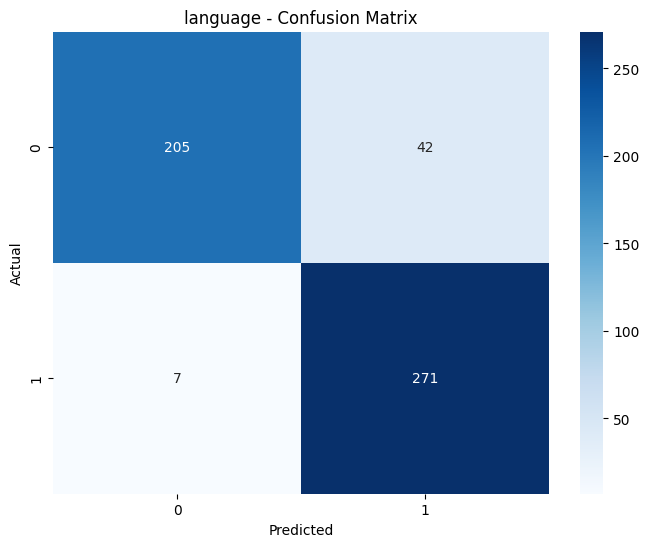

📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.16batch/s, loss=0.145]


Epoch [5/10]
Loss:		0.2101,	Accuracy:	0.9159
Val Loss:	0.1449,	Val Accuracy:	0.9371

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       247
           1       0.95      0.94      0.94       278

    accuracy                           0.94       525
   macro avg       0.94      0.94      0.94       525
weighted avg       0.94      0.94      0.94       525



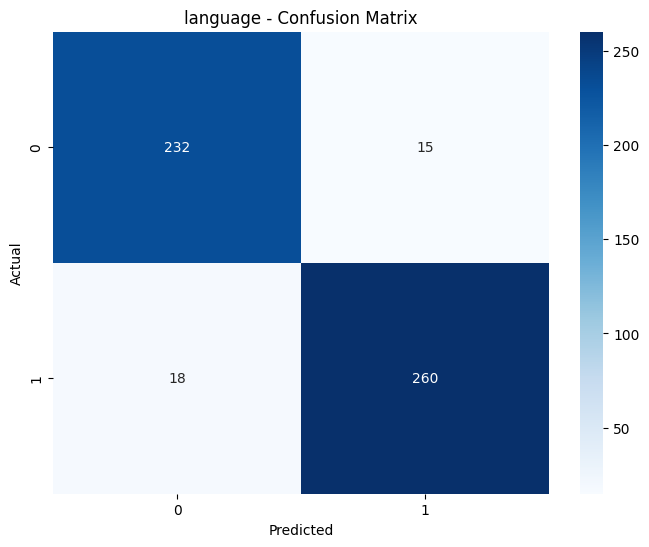

📄 Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.17batch/s, loss=0.17]


Epoch [6/10]
Loss:		0.1696,	Accuracy:	0.9327
Val Loss:	0.1697,	Val Accuracy:	0.9238

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       247
           1       0.91      0.95      0.93       278

    accuracy                           0.92       525
   macro avg       0.93      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525



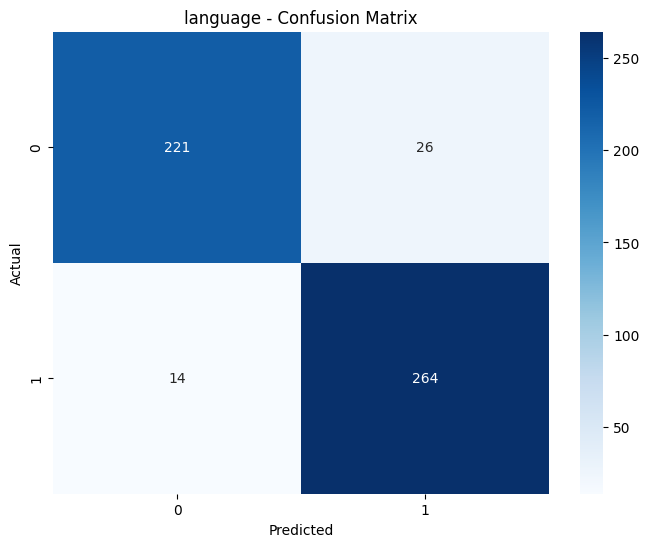

📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.96batch/s, loss=0.124]


Epoch [7/10]
Loss:		0.1891,	Accuracy:	0.9196
Val Loss:	0.1244,	Val Accuracy:	0.9486

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       247
           1       0.95      0.95      0.95       278

    accuracy                           0.95       525
   macro avg       0.95      0.95      0.95       525
weighted avg       0.95      0.95      0.95       525



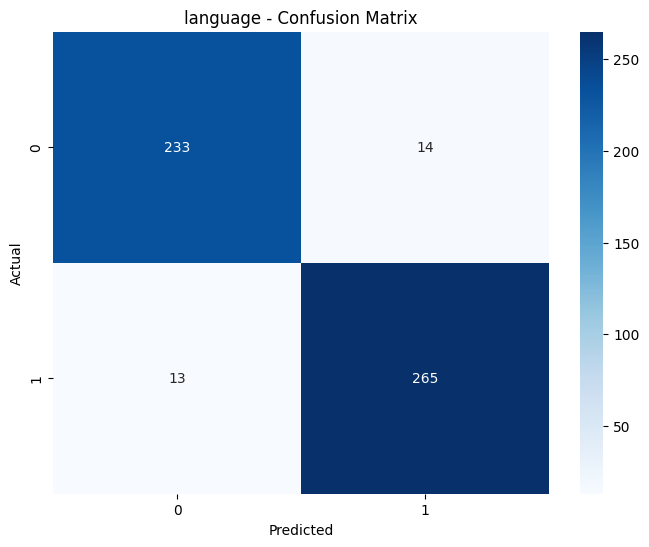

📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.13batch/s, loss=0.172]


Epoch [8/10]
Loss:		0.1451,	Accuracy:	0.9473
Val Loss:	0.1717,	Val Accuracy:	0.9333

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       247
           1       1.00      0.88      0.93       278

    accuracy                           0.93       525
   macro avg       0.94      0.94      0.93       525
weighted avg       0.94      0.93      0.93       525



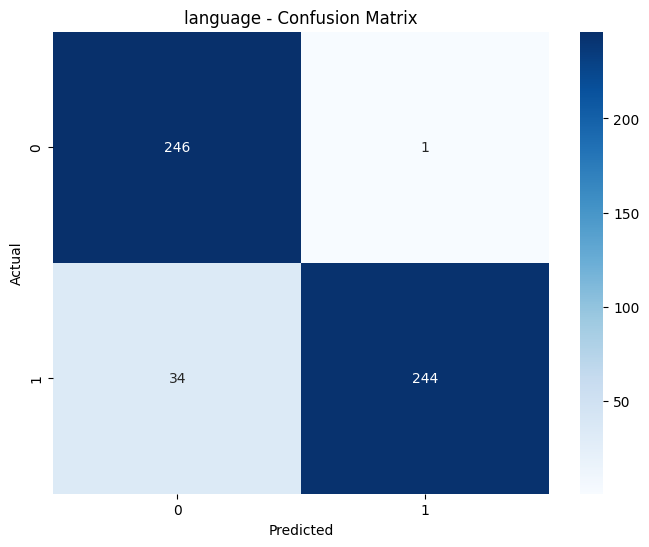

📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.10batch/s, loss=0.159]


Epoch [9/10]
Loss:		0.1251,	Accuracy:	0.9543
Val Loss:	0.1590,	Val Accuracy:	0.9352

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.98      0.89      0.94       278

    accuracy                           0.94       525
   macro avg       0.94      0.94      0.94       525
weighted avg       0.94      0.94      0.94       525



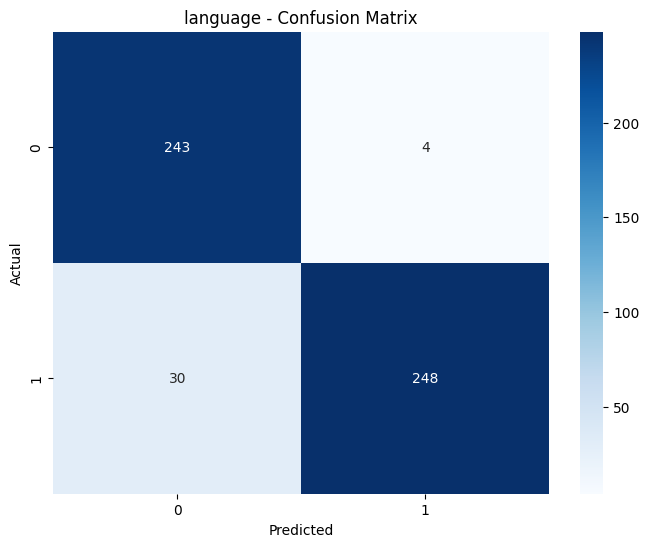

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 19.20batch/s, loss=0.0865]


Epoch [10/10]
Loss:		0.1480,	Accuracy:	0.9388
Val Loss:	0.0865,	Val Accuracy:	0.9733

✅ Epoch completed, evaluating the task
language - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       247
           1       0.96      0.99      0.98       278

    accuracy                           0.97       525
   macro avg       0.97      0.97      0.97       525
weighted avg       0.97      0.97      0.97       525



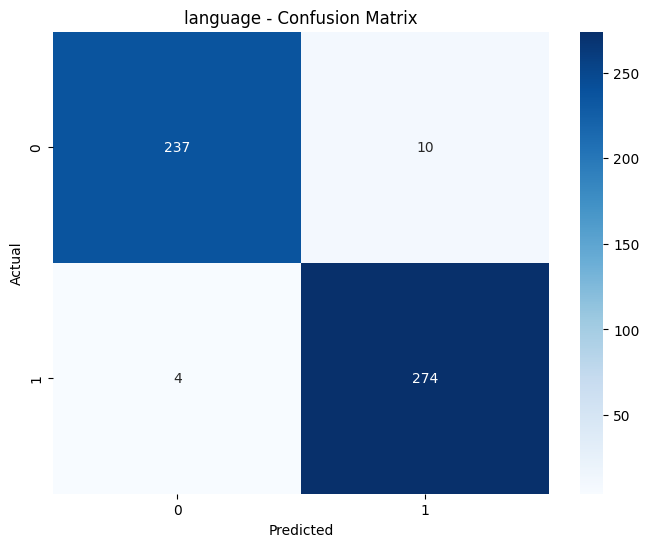

In [53]:
# Define the parameters for the language classification model
trainable_layers_idx = [-1, -2, -3, -4, -5]  # Specify which layers to unfreeze
model2 = customVGG16(add_feat_dims=[512], h_dims=[256, 128], input_size=(3, 224, 224), trainable_layers_idx=trainable_layers_idx)

# Setup TensorBoard for logging
writer = SummaryWriter(log_dir='runs/custom_vgg16_language_experiment')

# Define an optimizer and loss function
opt = optim.Adam(model2.parameters(), lr=0.001)  # Adam optimizer
loss_fn = nn.CrossEntropyLoss()  # Common loss for classification tasks

# Number of epochs to train
num_epochs = 10  # Adjust as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training the model for language classification
train(model2, opt, loss_fn, train_loader, val_loader, epochs=num_epochs, writer=writer, device=device, task='language')

# Close the TensorBoard writer
writer.close()

use `evaluate_task` to evlauate you model2 here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Language - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       175
           1       0.99      0.93      0.96       175

    accuracy                           0.96       350
   macro avg       0.96      0.96      0.96       350
weighted avg       0.96      0.96      0.96       350

```

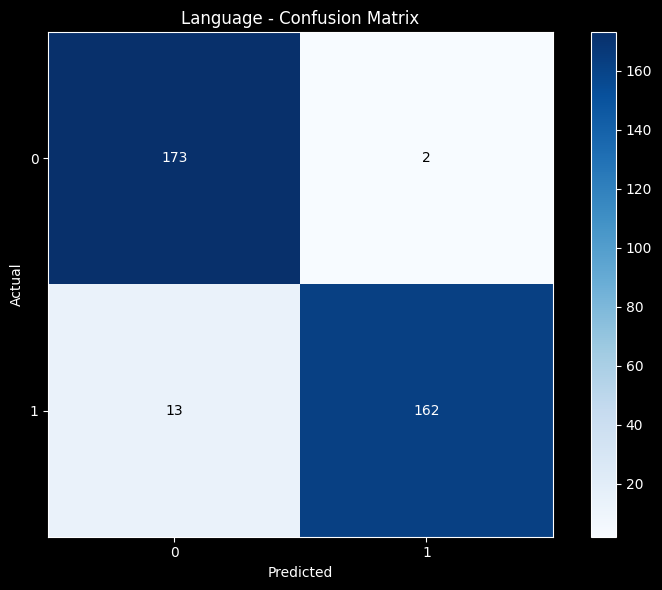

</details>

Test Accuracy: 0.9676
language - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       273
           1       0.95      0.98      0.97       252

    accuracy                           0.97       525
   macro avg       0.97      0.97      0.97       525
weighted avg       0.97      0.97      0.97       525



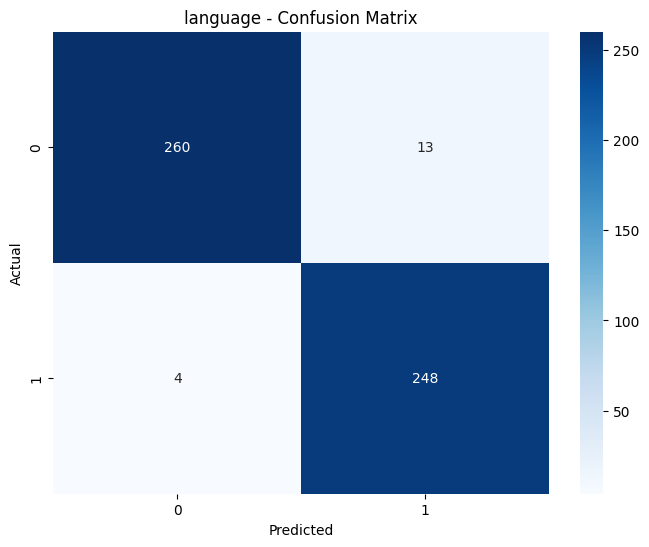

In [66]:
### START CODE HERE ###
evaluate_on_test_set(model2, test_loader, device, task = 'language')
### END CODE HERE ###

---

## Multitask learning

Complete the `customVGG16_multitask` class below, which can create a pretrained VGG16 model and customize the number of fully connected (FC) layers. It also allows adding new convolutional layers and unfreezing pretrained layers based on their index. Additionally, it allows branching the model into two heads for multitask learning, where one head handles digit classification, and the other handles language classification

In [10]:
import torch
import torch.nn as nn
from torchvision import models

class customVGG16_multitask(nn.Module):
    def __init__(self, add_feat_dims=None, h_dims=None, input_size=(3, 224, 224), trainable_layers_idx=None):
        super(customVGG16_multitask, self).__init__()

        # Load pretrained VGG16 model
        self.vgg16 = models.vgg16(weights='DEFAULT')
        
        # The first layer already accepts 3 channels (RGB), no need to modify
        # Get the input size for the fully connected layer
        self.input_fc_size = self._get_input_size_fc(input_size)
        
        # Adding additional feature dimensions
        self.fc_layers = []
        if h_dims:
            in_features = self.input_fc_size
            for h_dim in h_dims:
                self.fc_layers.append(nn.Linear(in_features, h_dim))
                self.fc_layers.append(nn.ReLU())
                in_features = h_dim
            
        # Append the additional layers only if add_feat_dims is specified
        if add_feat_dims is not None:
            self.fc_layers.append(nn.Linear(in_features, add_feat_dims))
            self.fc_layers.append(nn.ReLU())
            in_features = add_feat_dims
        
        # Final output layers for multitask learning
        self.digit_fc = nn.Linear(in_features, 10)  # Assuming 10 digits (0-9)
        self.lang_fc = nn.Linear(in_features, len(languages))  # Number of languages based on input

        self.fc_layers = nn.Sequential(*self.fc_layers)

        # Freeze layers if specified
        if trainable_layers_idx is not None:
            for i, layer in enumerate(self.vgg16.features):
                if i not in trainable_layers_idx:
                    for param in layer.parameters():
                        param.requires_grad = False

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.vgg16.features(x)  # Pass through feature extractor
            x = self.vgg16.avgpool(x)   # Average pooling
            x = torch.flatten(x, 1)      # Flatten for the fully connected layer
            return x.size(1)             # Return the size of the flattened output

    def forward(self, x):
        x = self.vgg16.features(x)  # Extract features
        x = self.vgg16.avgpool(x)   # Average pooling
        x = torch.flatten(x, 1)      # Flatten for the fully connected layer
        
        x = self.fc_layers(x)        # Pass through custom FC layers
        
        # Outputs for both tasks
        out1 = self.digit_fc(x)      # Digit classification
        out2 = self.lang_fc(x)       # Language classification
        
        return out1, out2


Complete the `train_multi` function below, which train multitask model and  logs Loss/train, Accuracy/train, Loss/test, and Accuracy/test to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).

In [11]:
def train_multi(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    print("🤖 Training on", device)
    model = model.to(device)  # Move model to device

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss, train_correct_digit, train_correct_lang = 0.0, 0, 0
        total_train = 0

        # Training loop with progress bar
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch + 1}/{epochs}]', unit='batch')
        for images, labels, languages in train_bar:
            images = images.to(device)
            labels = labels.to(device)
            languages = languages.to(device)

            # Forward pass
            outputs_digit, outputs_lang = model(images)
            loss_digit = loss_fn(outputs_digit, labels)
            loss_lang = loss_fn(outputs_lang, languages)
            loss = loss_digit + loss_lang

            # Backward pass and optimization
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Calculate training loss and accuracy
            train_loss += loss.item()
            _, predicted_digit = torch.max(outputs_digit.data, 1)
            _, predicted_lang = torch.max(outputs_lang.data, 1)
            train_correct_digit += (predicted_digit == labels).sum().item()
            train_correct_lang += (predicted_lang == languages).sum().item()
            total_train += labels.size(0)

            # Update progress bar
            train_bar.set_postfix(loss=train_loss / (len(train_bar)))

        # Log training metrics to TensorBoard
        train_loss /= len(train_loader)
        train_accuracy_digit = train_correct_digit / total_train
        train_accuracy_lang = train_correct_lang / total_train
        if writer:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train_digit', train_accuracy_digit, epoch)
            writer.add_scalar('Accuracy/train_lang', train_accuracy_lang, epoch)

        # Validation loop with progress bar
        model.eval()  # Set the model to evaluation mode
        val_loss, val_correct_digit, val_correct_lang = 0.0, 0, 0
        total_val = 0
        y_true_digit, y_pred_digit = [], []
        y_true_lang, y_pred_lang = [], []

        val_bar = tqdm(val_loader, desc='📄 Validation', unit='batch')
        with torch.no_grad():
            for images, labels, languages in val_bar:
                images = images.to(device)
                labels = labels.to(device)
                languages = languages.to(device)

                # Forward pass
                outputs_digit, outputs_lang = model(images)
                loss_digit = loss_fn(outputs_digit, labels)
                loss_lang = loss_fn(outputs_lang, languages)
                loss = loss_digit + loss_lang

                # Calculate validation loss and accuracy
                val_loss += loss.item()
                _, predicted_digit = torch.max(outputs_digit.data, 1)
                _, predicted_lang = torch.max(outputs_lang.data, 1)
                val_correct_digit += (predicted_digit == labels).sum().item()
                val_correct_lang += (predicted_lang == languages).sum().item()
                total_val += labels.size(0)

                # Collect true and predicted labels for evaluation
                y_true_digit.extend(labels.cpu().numpy())
                y_pred_digit.extend(predicted_digit.cpu().numpy())
                y_true_lang.extend(languages.cpu().numpy())
                y_pred_lang.extend(predicted_lang.cpu().numpy())

                # Update validation progress bar
                val_bar.set_postfix(loss=val_loss / (len(val_bar)))

        # Log validation metrics to TensorBoard
        val_loss /= len(val_loader)
        val_accuracy_digit = val_correct_digit / total_val
        val_accuracy_lang = val_correct_lang / total_val
        if writer:
            writer.add_scalar('Loss/val', val_loss, epoch)
            writer.add_scalar('Accuracy/val_digit', val_accuracy_digit, epoch)
            writer.add_scalar('Accuracy/val_lang', val_accuracy_lang, epoch)

        print(f'Epoch [{epoch + 1}/{epochs}]\n'
              f'Train Loss:\t{train_loss:.4f},\t'
              f'Train Accuracy Digit:\t{train_accuracy_digit:.4f},\t'
              f'Train Accuracy Lang:\t{train_accuracy_lang:.4f},\n'
              f'Val Loss:\t{val_loss:.4f},\t'
              f'Val Accuracy Digit:\t{val_accuracy_digit:.4f},\t'
              f'Val Accuracy Lang:\t{val_accuracy_lang:.4f}')

        # Save checkpoint if path is provided
        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)

        print("\n✅ Epoch completed, evaluating the task")
        # Evaluate tasks if specified
        evaluate_task(y_true_digit, y_pred_digit, task_name="digit")
        evaluate_task(y_true_lang, y_pred_lang, task_name="language")

🤖 Training on cuda


📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.85batch/s, loss=0.504]


Epoch [1/10]
Train Loss:	0.8259,	Train Accuracy Digit:	0.7629,	Train Accuracy Lang:	0.9698,
Val Loss:	0.5035,	Val Accuracy Digit:	0.8476,	Val Accuracy Lang:	0.9848

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.88        51
           1       0.91      0.89      0.90        47
           2       0.95      0.90      0.92        58
           3       1.00      0.74      0.85        53
           4       0.80      0.85      0.82        60
           5       0.83      0.68      0.75        50
           6       0.90      0.77      0.83        48
           7       0.74      0.88      0.80        49
           8       0.80      0.92      0.86        62
           9       0.83      0.85      0.84        47

    accuracy                           0.85       525
   macro avg       0.86      0.85      0.85       525
weighted avg       0.86      0.85      0.85       525



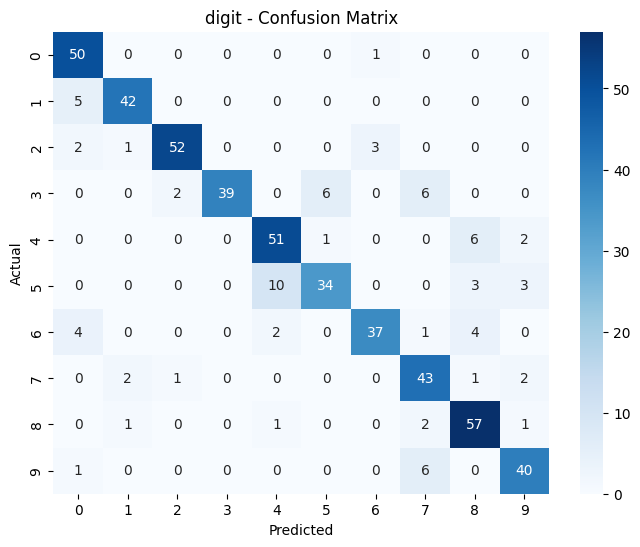

language - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       271
           1       0.98      0.98      0.98       254

    accuracy                           0.98       525
   macro avg       0.98      0.98      0.98       525
weighted avg       0.98      0.98      0.98       525



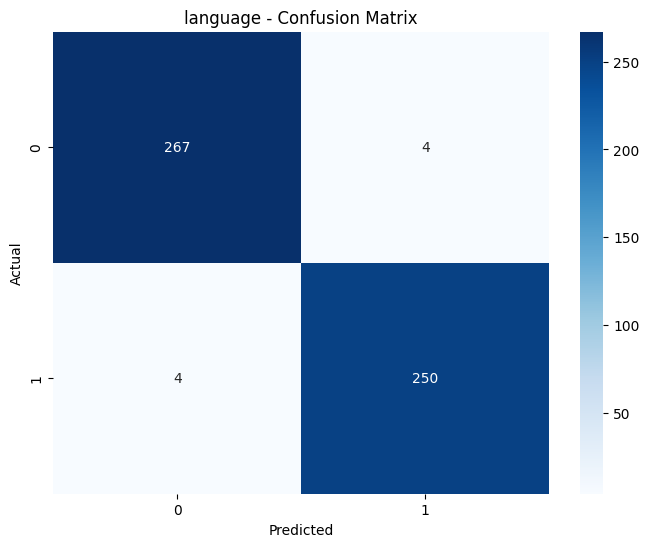

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.66batch/s, loss=0.338]


Epoch [2/10]
Train Loss:	0.1826,	Train Accuracy Digit:	0.9478,	Train Accuracy Lang:	0.9963,
Val Loss:	0.3383,	Val Accuracy Digit:	0.9067,	Val Accuracy Lang:	0.9962

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        51
           1       0.88      0.98      0.93        47
           2       0.96      0.90      0.93        58
           3       0.83      0.94      0.88        53
           4       0.92      0.92      0.92        60
           5       0.89      0.94      0.91        50
           6       0.92      0.92      0.92        48
           7       0.81      0.90      0.85        49
           8       0.96      0.81      0.88        62
           9       1.00      0.83      0.91        47

    accuracy                           0.91       525
   macro avg       0.91      0.91      0.91       525
weighted avg       0.91      0.91      0.91       525



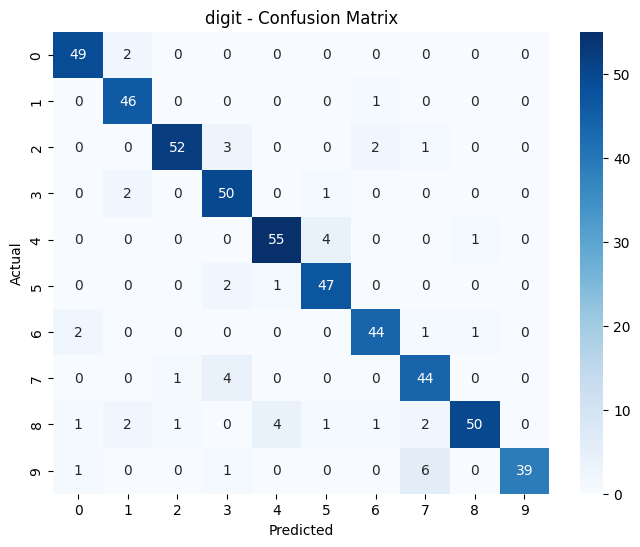

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       271
           1       1.00      1.00      1.00       254

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



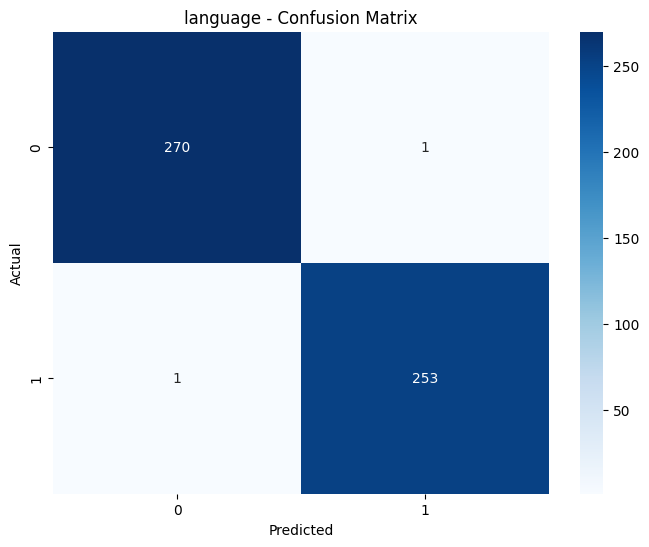

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.22batch/s, loss=0.395]


Epoch [3/10]
Train Loss:	0.0998,	Train Accuracy Digit:	0.9686,	Train Accuracy Lang:	0.9976,
Val Loss:	0.3955,	Val Accuracy Digit:	0.9105,	Val Accuracy Lang:	0.9962

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92        51
           1       0.94      0.98      0.96        47
           2       0.96      0.86      0.91        58
           3       0.86      0.96      0.91        53
           4       0.98      0.82      0.89        60
           5       0.90      0.94      0.92        50
           6       0.96      0.90      0.92        48
           7       0.79      0.94      0.86        49
           8       0.93      0.89      0.91        62
           9       0.95      0.87      0.91        47

    accuracy                           0.91       525
   macro avg       0.91      0.91      0.91       525
weighted avg       0.92      0.91      0.91       525



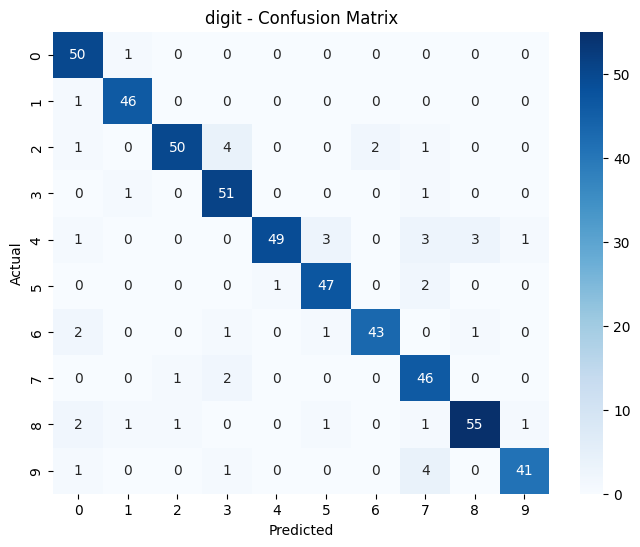

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       271
           1       0.99      1.00      1.00       254

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



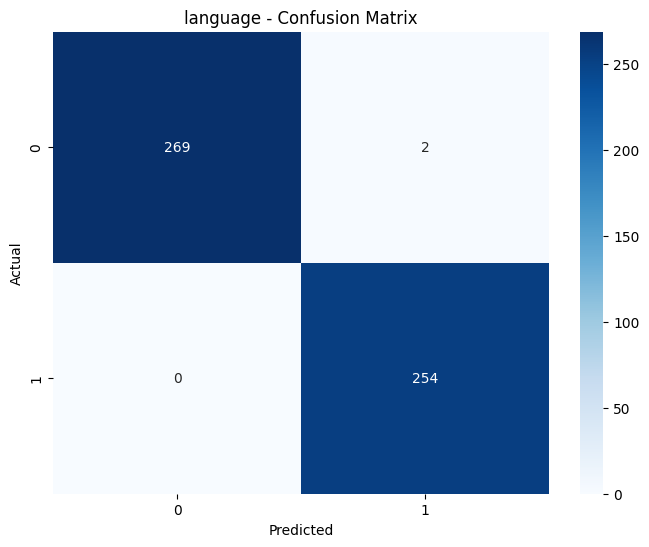

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.37batch/s, loss=0.414]


Epoch [4/10]
Train Loss:	0.0760,	Train Accuracy Digit:	0.9841,	Train Accuracy Lang:	0.9943,
Val Loss:	0.4144,	Val Accuracy Digit:	0.9219,	Val Accuracy Lang:	0.9962

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        51
           1       0.92      0.96      0.94        47
           2       0.98      0.93      0.96        58
           3       0.80      1.00      0.89        53
           4       0.92      0.95      0.93        60
           5       0.98      0.82      0.89        50
           6       1.00      0.85      0.92        48
           7       0.88      0.90      0.89        49
           8       0.86      0.97      0.91        62
           9       1.00      0.94      0.97        47

    accuracy                           0.92       525
   macro avg       0.93      0.92      0.92       525
weighted avg       0.93      0.92      0.92       525



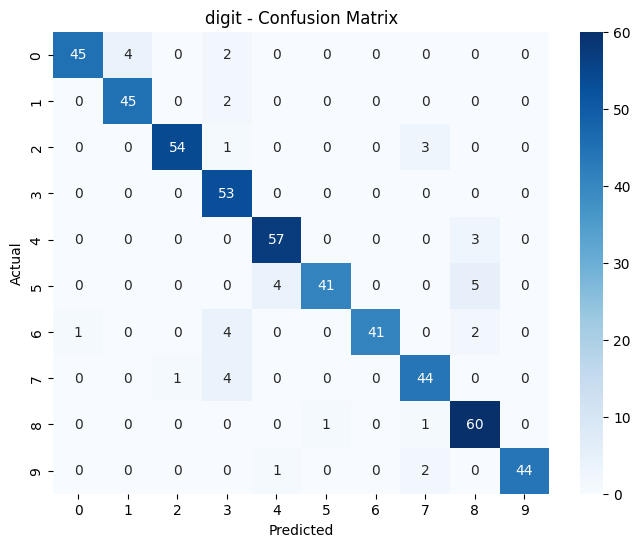

language - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       271
           1       1.00      0.99      1.00       254

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



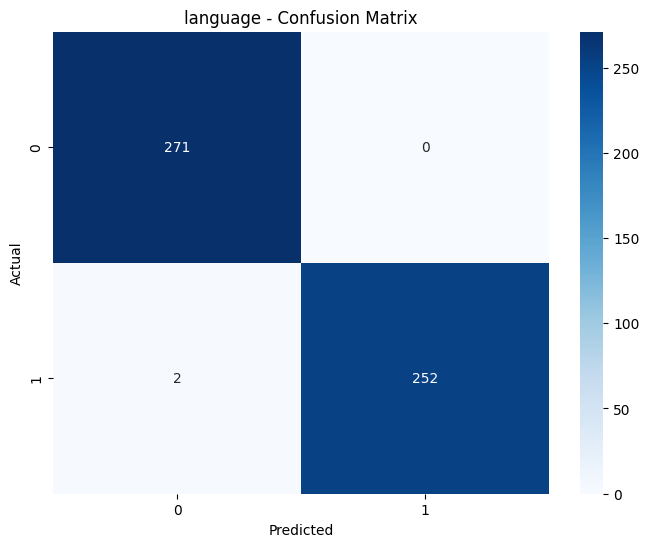

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.36batch/s, loss=0.351]


Epoch [5/10]
Train Loss:	0.0678,	Train Accuracy Digit:	0.9816,	Train Accuracy Lang:	0.9996,
Val Loss:	0.3515,	Val Accuracy Digit:	0.9181,	Val Accuracy Lang:	0.9981

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        51
           1       0.98      0.98      0.98        47
           2       0.90      0.97      0.93        58
           3       0.96      0.92      0.94        53
           4       0.92      0.77      0.84        60
           5       0.88      0.88      0.88        50
           6       0.98      0.96      0.97        48
           7       0.94      0.92      0.93        49
           8       0.75      0.94      0.83        62
           9       1.00      0.94      0.97        47

    accuracy                           0.92       525
   macro avg       0.93      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525



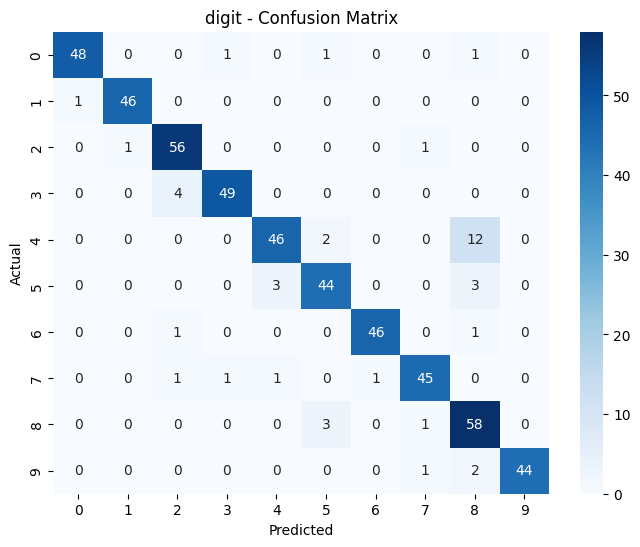

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       271
           1       1.00      1.00      1.00       254

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



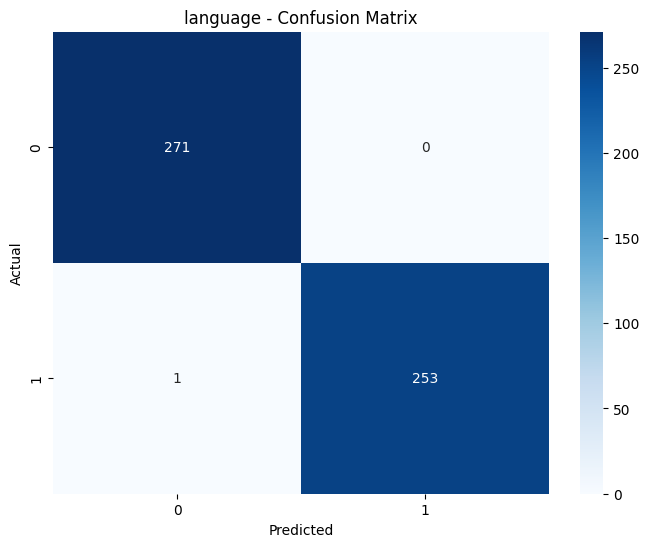

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.34batch/s, loss=0.281]


Epoch [6/10]
Train Loss:	0.0652,	Train Accuracy Digit:	0.9808,	Train Accuracy Lang:	0.9984,
Val Loss:	0.2812,	Val Accuracy Digit:	0.9200,	Val Accuracy Lang:	0.9962

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        51
           1       0.96      0.96      0.96        47
           2       0.98      0.90      0.94        58
           3       0.85      0.98      0.91        53
           4       0.88      0.93      0.90        60
           5       0.94      0.96      0.95        50
           6       0.98      0.83      0.90        48
           7       0.97      0.80      0.88        49
           8       0.89      0.90      0.90        62
           9       0.85      0.96      0.90        47

    accuracy                           0.92       525
   macro avg       0.93      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525



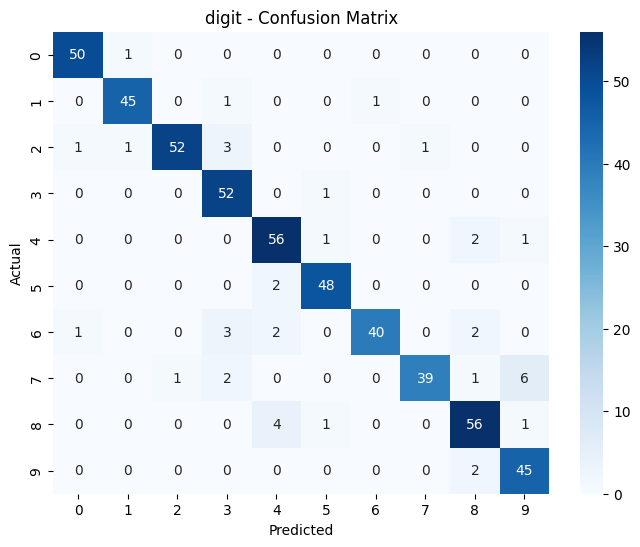

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       271
           1       0.99      1.00      1.00       254

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



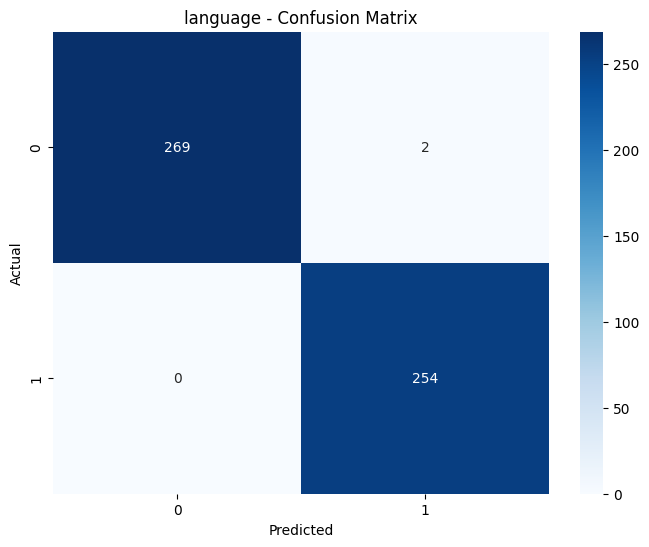

📄 Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.80batch/s, loss=0.28]


Epoch [7/10]
Train Loss:	0.0408,	Train Accuracy Digit:	0.9951,	Train Accuracy Lang:	0.9984,
Val Loss:	0.2800,	Val Accuracy Digit:	0.9352,	Val Accuracy Lang:	0.9943

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        51
           1       0.92      0.98      0.95        47
           2       0.95      0.95      0.95        58
           3       0.90      0.98      0.94        53
           4       1.00      0.88      0.94        60
           5       0.92      0.98      0.95        50
           6       0.98      0.88      0.92        48
           7       0.94      0.90      0.92        49
           8       0.85      0.98      0.91        62
           9       1.00      0.91      0.96        47

    accuracy                           0.94       525
   macro avg       0.94      0.93      0.94       525
weighted avg       0.94      0.94      0.94       525



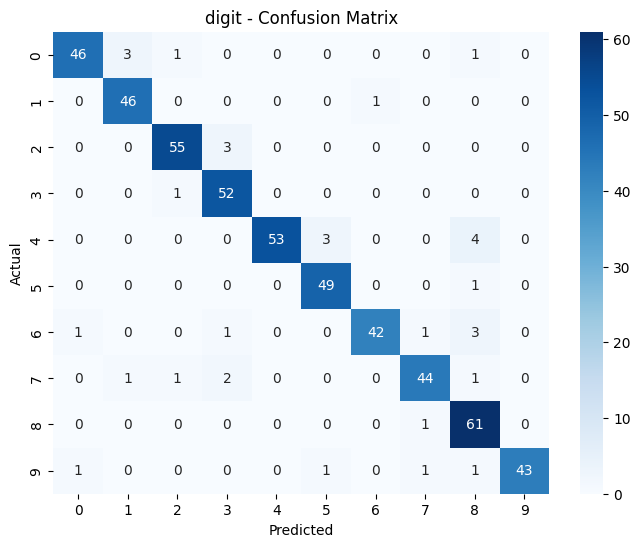

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       271
           1       0.99      1.00      0.99       254

    accuracy                           0.99       525
   macro avg       0.99      0.99      0.99       525
weighted avg       0.99      0.99      0.99       525



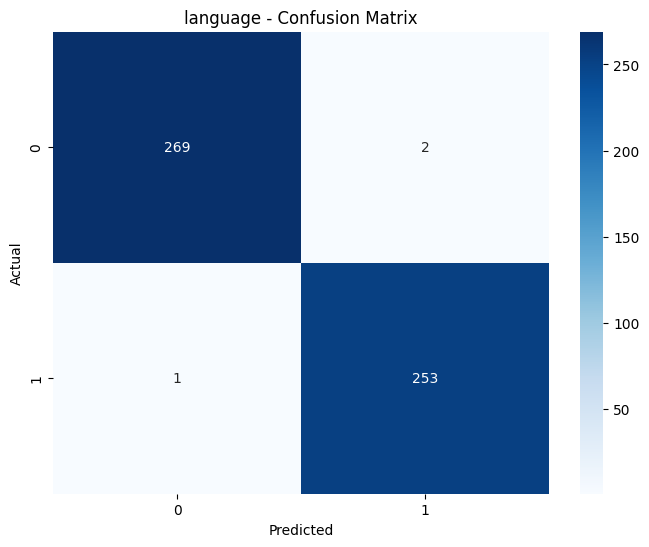

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.69batch/s, loss=0.229]


Epoch [8/10]
Train Loss:	0.0212,	Train Accuracy Digit:	0.9947,	Train Accuracy Lang:	0.9996,
Val Loss:	0.2287,	Val Accuracy Digit:	0.9352,	Val Accuracy Lang:	0.9981

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        51
           1       0.90      0.98      0.94        47
           2       0.96      0.93      0.95        58
           3       0.89      0.94      0.92        53
           4       0.93      0.93      0.93        60
           5       0.96      0.98      0.97        50
           6       0.96      0.90      0.92        48
           7       0.88      0.90      0.89        49
           8       0.95      0.89      0.92        62
           9       0.96      0.94      0.95        47

    accuracy                           0.94       525
   macro avg       0.94      0.94      0.94       525
weighted avg       0.94      0.94      0.94       525



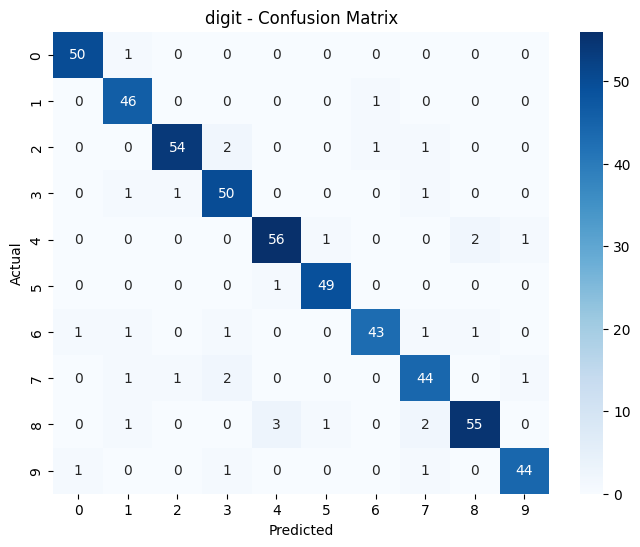

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       271
           1       1.00      1.00      1.00       254

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



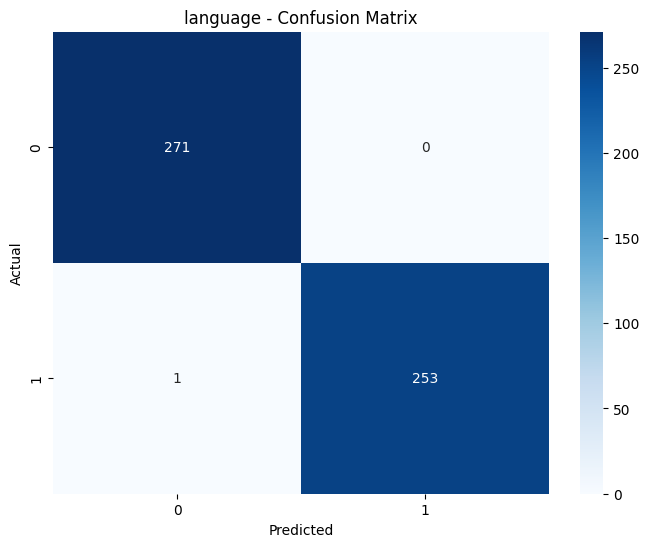

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.22batch/s, loss=0.331]


Epoch [9/10]
Train Loss:	0.0116,	Train Accuracy Digit:	0.9963,	Train Accuracy Lang:	1.0000,
Val Loss:	0.3307,	Val Accuracy Digit:	0.9410,	Val Accuracy Lang:	0.9981

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        51
           1       0.98      0.98      0.98        47
           2       0.93      0.91      0.92        58
           3       0.91      0.94      0.93        53
           4       1.00      0.87      0.93        60
           5       0.92      0.96      0.94        50
           6       0.92      0.94      0.93        48
           7       0.96      0.92      0.94        49
           8       0.90      0.98      0.94        62
           9       0.94      0.96      0.95        47

    accuracy                           0.94       525
   macro avg       0.94      0.94      0.94       525
weighted avg       0.94      0.94      0.94       525



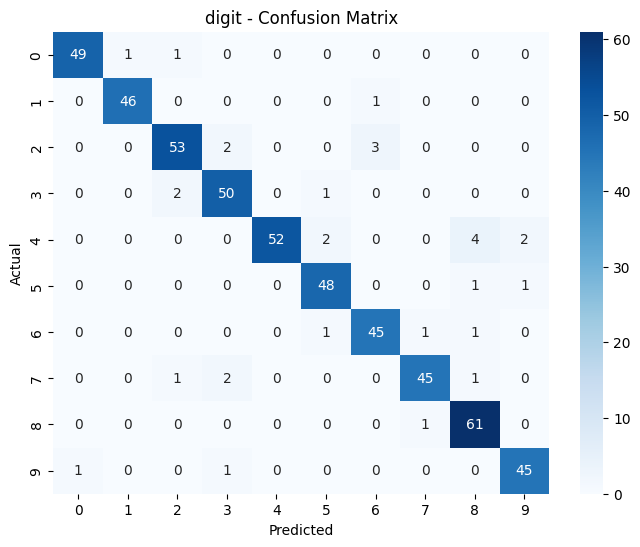

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       271
           1       1.00      1.00      1.00       254

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



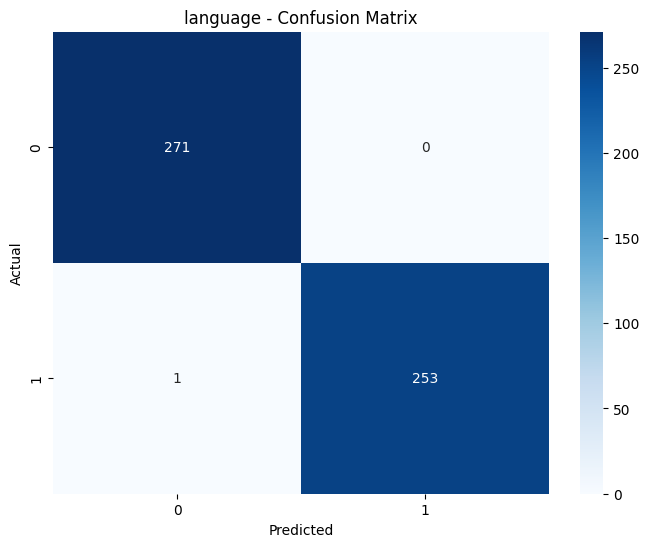

📄 Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.08batch/s, loss=0.301]


Epoch [10/10]
Train Loss:	0.0003,	Train Accuracy Digit:	1.0000,	Train Accuracy Lang:	1.0000,
Val Loss:	0.3013,	Val Accuracy Digit:	0.9429,	Val Accuracy Lang:	0.9962

✅ Epoch completed, evaluating the task
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       0.98      0.98      0.98        47
           2       0.95      0.95      0.95        58
           3       0.91      0.94      0.93        53
           4       0.98      0.90      0.94        60
           5       0.89      0.96      0.92        50
           6       0.96      0.92      0.94        48
           7       0.98      0.92      0.95        49
           8       0.89      0.95      0.92        62
           9       0.94      0.94      0.94        47

    accuracy                           0.94       525
   macro avg       0.95      0.94      0.94       525
weighted avg       0.94      0.94      0.94       525



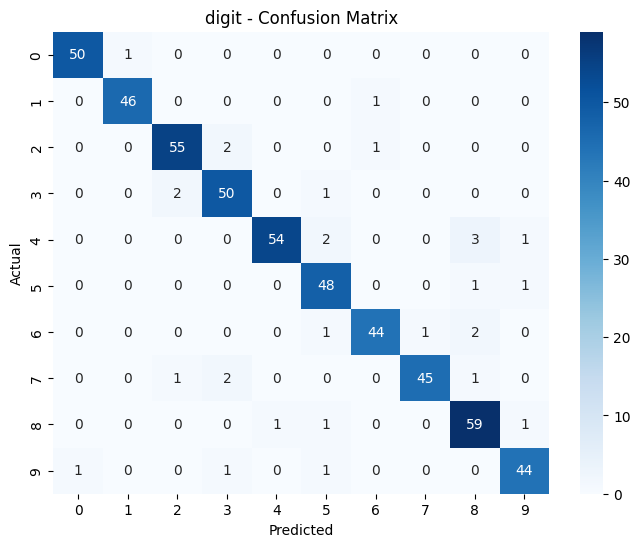

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       271
           1       1.00      1.00      1.00       254

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



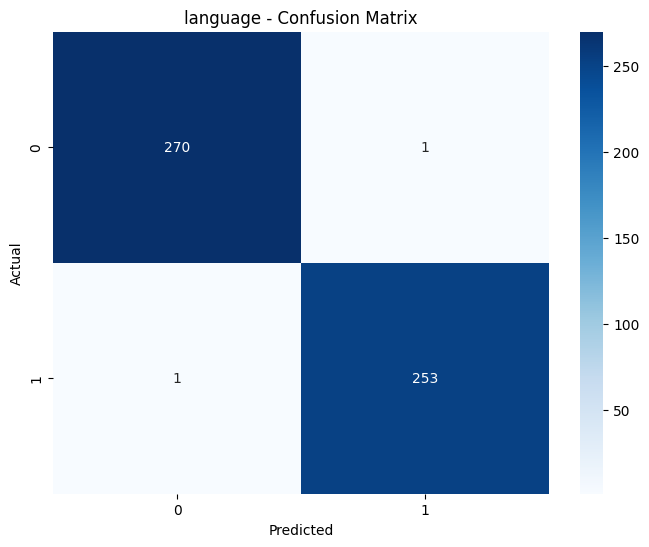

In [14]:
### START CODE HERE ###
# Initialize the model for multitask learning
model = customVGG16_multitask(add_feat_dims=128, h_dims=[256, 128], trainable_layers_idx=[i for i in range(10)])


# Setup TensorBoard for logging
writer = SummaryWriter(log_dir='runs/custom_vgg16_multitask_experiment')

# Define an optimizer and loss function
opt = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
loss_fn = nn.CrossEntropyLoss()  # Common loss for classification tasks

num_epochs = 10  # Set number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the multitask model
train_multi(model, opt, loss_fn, train_loader, val_loader, epochs=num_epochs, writer=writer, device=device)
### END CODE HERE ###


use `evaluate_task` to evlauate you model here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.81      0.91      0.85        32
           2       0.76      0.55      0.64        40
           3       0.53      0.66      0.58        32
           4       0.54      0.29      0.38        24
           5       0.51      0.57      0.54        37
           6       0.68      0.72      0.70        29
           7       0.60      0.71      0.65        34
           8       0.62      0.71      0.66        48
           9       0.68      0.49      0.57        39

    accuracy                           0.65       350
   macro avg       0.66      0.65      0.64       350
weighted avg       0.66      0.65      0.65       350

```

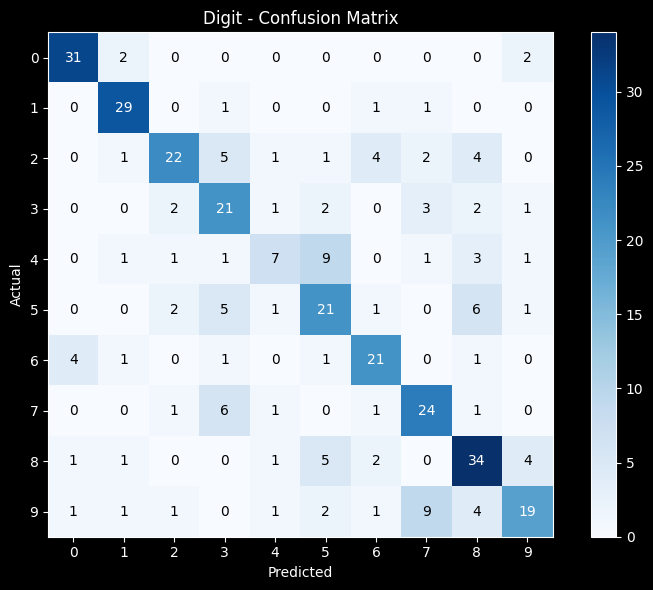

```
Language - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       172
           1       0.98      0.98      0.98       178

    accuracy                           0.98       350
   macro avg       0.98      0.98      0.98       350
weighted avg       0.98      0.98      0.98       350
```

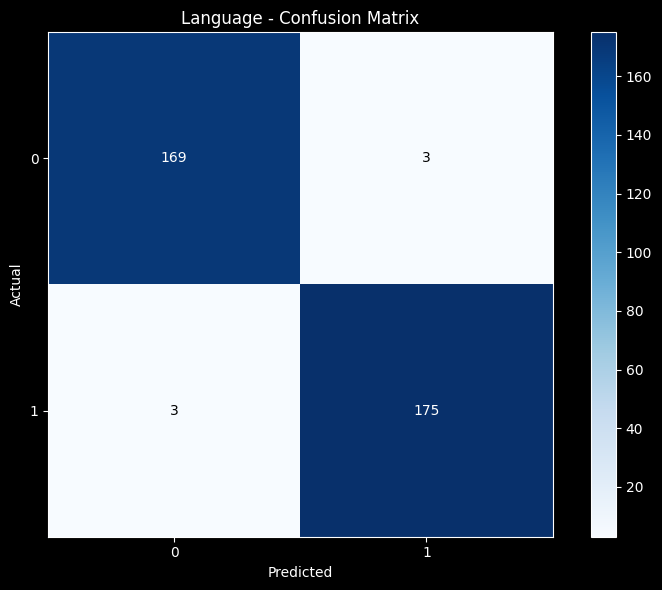

</details>

In [30]:
def evaluate_multi_task_on_test_set(model, test_loader, device):
    model.eval()
    test_loss, test_correct_digit, test_correct_lang = 0.0, 0, 0
    total_test_digit, total_test_lang = 0, 0
    y_true_digit, y_pred_digit = [], []
    y_true_lang, y_pred_lang = [], []

    with torch.no_grad():
        for images, labels, languages in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            languages = languages.to(device)

            # Forward pass
            outputs_digit, outputs_lang = model(images)
            loss_digit = loss_fn(outputs_digit, labels)
            loss_lang = loss_fn(outputs_lang, languages)
            loss = loss_digit + loss_lang
            test_loss += loss.item()

            # Get predictions
            _, predicted_digit = torch.max(outputs_digit, 1)
            _, predicted_lang = torch.max(outputs_lang, 1)

            # Calculate correct predictions
            test_correct_digit += (predicted_digit == labels).sum().item()
            test_correct_lang += (predicted_lang == languages).sum().item()
            total_test_digit += labels.size(0)
            total_test_lang += languages.size(0)

            # Collect true and predicted labels for evaluation
            y_true_digit.extend(labels.cpu().numpy())
            y_pred_digit.extend(predicted_digit.cpu().numpy())
            y_true_lang.extend(languages.cpu().numpy())
            y_pred_lang.extend(predicted_lang.cpu().numpy())

    # Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy_digit = test_correct_digit / total_test_digit
    test_accuracy_lang = test_correct_lang / total_test_lang

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy Digit: {test_accuracy_digit:.4f}')
    print(f'Test Accuracy Language: {test_accuracy_lang:.4f}')

    # Evaluate tasks for metrics
    evaluate_task(y_true_digit, y_pred_digit, task_name="digit")
    evaluate_task(y_true_lang, y_pred_lang, task_name="language")


Test Loss: 0.2228
Test Accuracy Digit: 0.9600
Test Accuracy Language: 0.9962
digit - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.95      0.98      0.97        64
           2       0.96      0.94      0.95        49
           3       0.98      0.94      0.96        52
           4       0.89      0.95      0.92        44
           5       0.98      0.91      0.94        55
           6       0.98      0.98      0.98        44
           7       0.98      1.00      0.99        54
           8       0.92      1.00      0.96        61
           9       1.00      0.93      0.96        59

    accuracy                           0.96       525
   macro avg       0.96      0.96      0.96       525
weighted avg       0.96      0.96      0.96       525



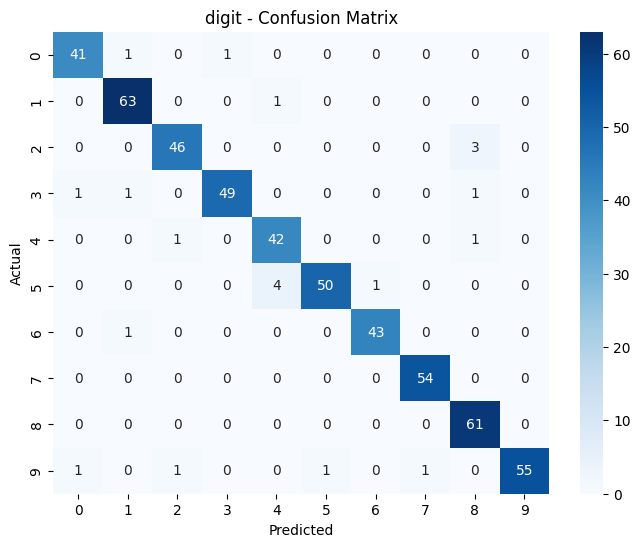

language - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       277
           1       0.99      1.00      1.00       248

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



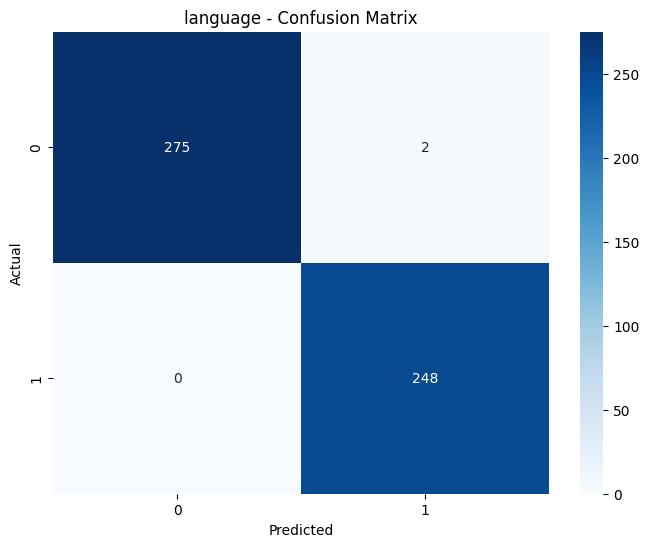

In [31]:
### START CODE HERE ###
evaluate_multi_task_on_test_set(model, test_loader, device)
### END CODE HERE ###

---
# Question
1. If you build two separate models, one for each task with a different classification problem, 
how does the overall model size of two separate models compared to a single model with shared layers and two classifiers 
at the end?

2. In what scenarios might a single model with two classifiers outperform two separate models in terms of generalization? Is there a risk of one task negatively affecting the other?

3. How can weighted loss functions be applied in a single model with two classifiers to balance the performance of both tasks?

---
# Answer
1. **การเปรียบเทียบขนาดโมเดลสำหรับงานหลายงาน**

    **กรณี 1: สร้างโมเดลแยกต่างหากสำหรับแต่ละงาน**

    - **ข้อดี:**
        - สามารถปรับแต่งแต่ละโมเดลให้เหมาะสมกับงานเฉพาะได้อย่างอิสระ
        - อาจมีประสิทธิภาพดีกว่าหากงานทั้งสองไม่เกี่ยวข้องกันมากนัก
    - **ข้อเสีย:**
        - ต้องฝึกและประเมินโมเดลสองตัว ทำให้ใช้ทรัพยากรมากขึ้น
        - อาจเกิดปัญหาการ overfitting หากข้อมูลไม่เพียงพอสำหรับแต่ละงาน

    **กรณี 2: สร้างโมเดลเดียวที่มีเลเยอร์ร่วมกันและคลาสสิไฟเออร์แยกต่างหาก**

    - **ข้อดี:**
        - สามารถใช้เลเยอร์ร่วมกันเพื่อเรียนรู้ลักษณะทั่วไปของข้อมูล ทำให้ประหยัดทรัพยากรและอาจช่วยลดการ overfitting
        - เหมาะสำหรับงานที่เกี่ยวข้องกันหรือมีลักษณะร่วมกัน
    - **ข้อเสีย:**
        - อาจจำเป็นต้องปรับแต่งเลเยอร์ร่วมกันให้เหมาะสมกับทั้งสองงาน
        - อาจเกิดปัญหาการ interference (หมายถึงสถานการณ์ที่การเรียนรู้ของงานหนึ่งไปขัดขวางหรือรบกวนการเรียนรู้ของงานอื่น ๆ ที่ใช้เลเยอร์ร่วมกัน) หากงานทั้งสองมีลักษณะแตกต่างกันมาก

---
2. **การเปรียบเทียบโมเดลเดียวกับสองโมเดลแยกต่างหากในแง่ของการทั่วไป**

    **กรณีที่โมเดลเดียวอาจมีประสิทธิภาพดีกว่า:**

    - งานที่เกี่ยวข้องกัน: หากงานทั้งสองมีความเกี่ยวข้องกันหรือมีลักษณะร่วมกัน การใช้โมเดลเดียวที่มีเลเยอร์ร่วมกันสามารถช่วยให้โมเดลเรียนรู้ลักษณะทั่วไปของข้อมูลได้ดีขึ้น ทำให้สามารถทั่วไป (generalize) ได้ดีกว่าโมเดลแยกต่างหาก
    - ข้อมูลจำกัด: หากข้อมูลสำหรับแต่ละงานมีจำกัด การใช้โมเดลเดียวสามารถช่วยลดการ overfitting โดยแบ่งปันน้ำหนักระหว่างงานทั้งสอง
    - ความซับซ้อนของโมเดล: โมเดลเดียวที่มีเลเยอร์ร่วมกันอาจมีขนาดเล็กลงกว่าโมเดลแยกต่างหาก ทำให้ฝึกได้ง่ายขึ้นและมีโอกาสทั่วไปได้ดีขึ้น

    **ความเสี่ยงของการแทรกแซง:**

    แม้ว่าโมเดลเดียวที่มีเลเยอร์ร่วมกันอาจมีประสิทธิภาพดีกว่าในบางกรณี แต่ก็มีความเสี่ยงของการแทรกแซง (interference) ที่อาจทำให้ประสิทธิภาพของหนึ่งงานลดลง หากงานทั้งสองมีความแตกต่างกันมาก หรือหากข้อมูลสำหรับงานหนึ่งมีอิทธิพลมากเกินไป

---
3. **การใช้ฟังก์ชันการสูญเสียแบบถ่วงน้ำหนักในโมเดลเดียวที่มีคลาสสิไฟเออร์สองตัว**

    ฟังก์ชันการสูญเสียแบบถ่วงน้ำหนัก (Weighted Loss Function) เป็นเทคนิคที่ใช้ปรับน้ำหนักของแต่ละตัวอย่างหรือคลาสในฟังก์ชันการสูญเสีย เพื่อให้โมเดลให้ความสำคัญกับตัวอย่างหรือคลาสบางตัวมากกว่าตัวอย่างหรือคลาสอื่น ๆ

    **การประยุกต์ใช้ในโมเดลเดียวที่มีคลาสสิไฟเออร์สองตัว:**

    - กำหนดน้ำหนักสำหรับแต่ละงาน: กำหนดน้ำหนักให้กับแต่ละงานตามความสำคัญที่ต้องการให้โมเดลให้ความสำคัญกับงานนั้น
    - ปรับปรุงการฝึก: ในกรณีที่งานหนึ่งมีข้อมูลไม่เพียงพอหรือมีความไม่สมดุลในกลุ่มข้อมูล การให้ความสำคัญกับฟังก์ชันการสูญเสียของงานนั้น (เช่น เพิ่มน้ำหนัก) จะช่วยให้โมเดลสามารถเรียนรู้ได้ดีขึ้นจากข้อมูลที่มีอยู่
    - ลดอคติในการเรียนรู้: เมื่อฟังก์ชันการสูญเสียของหนึ่งในงานมีค่ามากกว่าหรือประสิทธิภาพไม่ดี การปรับน้ำหนักให้สูงขึ้นสำหรับงานนั้นสามารถช่วยให้โมเดลไม่ละเลยงานนี้ และปรับปรุงประสิทธิภาพได้
    - คำนวณการสูญเสียแบบถ่วงน้ำหนัก: คูณการสูญเสียของแต่ละงานด้วยน้ำหนักที่กำหนดไว้ แล้วบวกกันเพื่อได้การสูญเสียแบบถ่วงน้ำหนัก
    - ปรับปรุงโมเดล: ใช้การสูญเสียแบบถ่วงน้ำหนักในการฝึกโมเดล

    **ตัวอย่าง:**
    ```python
    weight_task1 = 0.3
    weight_task2 = 0.7

    loss_task1 = criterion_task1(output1, target1)
    loss_task2 = criterion_task2(output2, target2)

    weighted_loss = weight_task1 * loss_task1 + weight_task2 * loss_task2
    ```


    **ข้อดีของการใช้ฟังก์ชันการสูญเสียแบบถ่วงน้ำหนัก:**
    
        - สามารถปรับสมดุลระหว่างงานที่มีความไม่สมดุลกัน
        - สามารถเพิ่มความสำคัญของงานที่ต้องการให้โมเดลให้ความสำคัญมากขึ้น
        - สามารถปรับปรุงประสิทธิภาพของโมเดลโดยรวม